In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [28]:
# Global parameters
total_years = 20 # this will be calculated based on study start and end dates
# Adoption model differential eq Parameters
dt = 1/12  # time step in years (monthly)
time = np.arange(0, total_years, dt)
n = len(time)

In [29]:
### feature request ###
#######################
 #this value will be an input table from the characterizer #these need to be per competition group and building type
# Use input sheet 30_Construction_Inputs.xlsx


nc_per_year = 10 #this value will be an input table from the characterizer #these need to be per competition group and building type
nc = nc_per_year * dt 
nc_arr = np.full(n, nc)  # Create an array for plotting this is the new construction per time step
# initialize an array of cumulative annual totals for nc
nc_cumulative_annual = np.zeros(n)
nc = nc_per_year * dt 
nc_arr = np.full(n, nc)
nc_cumulative_annual = np.cumsum(nc_arr)

# Demolition 
demo_per_year = 10 #this value will be an input table from the characterizer
demo = demo_per_year * dt 
demo_arr = np.full(n, demo)  # Create an array for plotting this is the demo per time step
# initialize an array of cumulative annual totals for nc
demo_cumulative_annual = np.zeros(n)
demo = demo_per_year * dt 
demo_arr = np.full(n, demo)
demo_cumulative_annual = np.cumsum(demo_arr)

# Renovation
reno_per_year = 10 #this value will be an input table from the characterizer
reno = reno_per_year * dt 
reno_arr = np.full(n, reno)  # Create an array for plotting this is the demo per time step
# initialize an array of cumulative annual totals for nc
reno_cumulative_annual = np.zeros(n)
reno = reno_per_year * dt 
reno_arr = np.full(n, reno)
reno_cumulative_annual = np.cumsum(reno_arr)

In [30]:
df = pd.read_pickle("./030_input/df_yrs.pkl")

#######################
### feature request ###
#######################
# Create competition allocation based on PCT test for efficient measures


# Define a function to extract the size
def extract_eff_level(description):
    if 'baseline' in description:
        return 'baseline'
    elif 'existing' in description:
        return 'existing'
    elif 'efficient' in description:
        return 'efficient'
    elif 'top10' in description:
        return 'top10' #this change is made because top10 is considered efficient in refrigeration for now just holding to get number right
    else:
        return 'Unknown'

# Apply the function to the 'Description' column to create the new 'Size' column
df['efficiency_level'] = df['condition_name'].apply(extract_eff_level)
df

condition_name competition_group  \
0            furnace_fuel_oil_existing_residential   heating_cooling   
1            furnace_fuel_oil_existing_residential   heating_cooling   
2            furnace_fuel_oil_existing_residential   heating_cooling   
3            furnace_fuel_oil_existing_residential   heating_cooling   
4            furnace_fuel_oil_existing_residential   heating_cooling   
...                                            ...               ...   
1339  insulation_natural_gas_efficient_residential        whole_home   
1340  insulation_natural_gas_efficient_residential        whole_home   
1341  insulation_natural_gas_efficient_residential        whole_home   
1342  insulation_natural_gas_efficient_residential        whole_home   
1343  insulation_natural_gas_efficient_residential        whole_home   

         subgroup electric_utility     gas_utility    building_type  \
0     oil_furnace   test_utility_1  test_utility_1    single_family   
1     oil_furnace   test_utility_1  test_utility_2    single_family   
2     oil_furnace   test_utility_2  test_utility_2    single_family   
3     oil_furnace   test_utility_1            none    single_family   
4     oil_furnace   test_utility_2            none    single_family   
...           ...              ...             ...              ...   
1339         none   test_utility_2  test_utility_2  multi_family_li   
1340         none   test_utility_1            none  multi_family_li   
1341         none   test_utility_2            none  multi_family_li   
1342         none             none  test_utility_1  multi_family_li   
1343         none             none  test_utility_2  multi_family_li   

      measure_life_(yrs)  initial_count  \
0                   10.0        10000.0   
1                   10.0        20000.0   
2                   10.0        55000.0   
3                   10.0        10000.0   
4                   10.0        11000.0   
...                  ...            ...   
1339                30.0          350.0   
1340                30.0          125.0   
1341                30.0          125.0   
1342                30.0          125.0   
1343                30.0          125.0   

                                         condition     market  ...  SCT_cost  \
0            furnace_fuel_oil_existing_residential        ROB  ...       NaN   
1            furnace_fuel_oil_existing_residential        ROB  ...       NaN   
2            furnace_fuel_oil_existing_residential        ROB  ...       NaN   
3            furnace_fuel_oil_existing_residential        ROB  ...       NaN   
4            furnace_fuel_oil_existing_residential        ROB  ...       NaN   
...                                            ...        ...  ...       ...   
1339  insulation_natural_gas_efficient_residential  REMAINING  ...       NaN   
1340  insulation_natural_gas_efficient_residential  REMAINING  ...       NaN   
1341  insulation_natural_gas_efficient_residential  REMAINING  ...       NaN   
1342  insulation_natural_gas_efficient_residential  REMAINING  ...       NaN   
1343  insulation_natural_gas_efficient_residential  REMAINING  ...       NaN   

      SCT_benefit SCT_BCR RIM_cost RIM_benefit RIM_BCR PCT_cost PCT_benefit  \
0             NaN     NaN      NaN         NaN     NaN      NaN         NaN   
1             NaN     NaN      NaN         NaN     NaN      NaN         NaN   
2             NaN     NaN      NaN         NaN     NaN      NaN         NaN   
3             NaN     NaN      NaN         NaN     NaN      NaN         NaN   
4             NaN     NaN      NaN         NaN     NaN      NaN         NaN   
...           ...     ...      ...         ...     ...      ...         ...   
1339          NaN     NaN      NaN         NaN     NaN      NaN         NaN   
1340          NaN     NaN      NaN         NaN     NaN      NaN         NaN   
1341          NaN     NaN      NaN         NaN     NaN      NaN         NaN   
1342          NaN     NaN      NaN         NaN    

In [31]:
#these retirement rates will come from the condition input sheet for each condition (can they be unique to each condition?)
#is er and Add on a calculable value?
rob_retirement_rate = 1
ret_er_retirement_rate = 0.02
ret_add_on_retirement_rate = 0.02

In [32]:
def baseline_eq_dynamic(substocks, m, retirement_rate, df_filtered=None):
    """
    Dynamic baseline equation that works with variable substocks.
    
    Parameters:
    -----------
    substocks : dict
        Dictionary with efficiency levels as keys and stock values as values
        e.g., {'baseline': 100, 'efficient': 50, 'top10': 25}
    m : float
        Total stock size
    retirement_rate : float
        Retirement rate for this market
    df_filtered : pd.DataFrame
        Filtered dataframe (not used in baseline, but kept for consistency)
    
    Returns:
    --------
    dict
        Dictionary with efficiency levels as keys and their dStock/dt values
    """
    Tech_Value = 0  # Baseline scenario: no adoption of efficient measures
    Retirement_Flow = m * retirement_rate
    
    # Initialize return dictionary
    d_substocks = {}
    
    # Calculate flows for each substock
    for level, stock_value in substocks.items():
        # All retirements stay at their current level in baseline scenario
        d_substocks[level] = -stock_value * retirement_rate
    
    # Add the retirement flow back to the same levels proportionally
    if m > 0:
        for level, stock_value in substocks.items():
            proportion = stock_value / m
            d_substocks[level] += Retirement_Flow * proportion
    
    return d_substocks


def tech_eq_dynamic(substocks, m, retirement_rate, df_filtered=None):
    """
    Dynamic technical potential equation that works with variable substocks.
    All retirements go to the highest efficiency level available.
    """
    Tech_Value = 1  # 100% adoption of best available technology
    Retirement_Flow = m * retirement_rate
    
    # Initialize return dictionary
    d_substocks = {}
    
    # Determine the highest efficiency level available
    efficiency_hierarchy = ['below_baseline', 'baseline', 'efficient', 'top10']
    available_levels = [level for level in efficiency_hierarchy if level in substocks]
    
    if not available_levels:
        return d_substocks
    
    highest_level = available_levels[-1]  # Get the highest available level
    
    # Calculate flows for each substock
    for level in available_levels:
        # All substocks lose stock due to retirement
        d_substocks[level] = -substocks[level] * retirement_rate
        
        # Only the highest level gains from retirements
        if level == highest_level:
            d_substocks[level] += Retirement_Flow * Tech_Value
    
    return d_substocks


def competition_eq_dynamic(substocks, m, retirement_rate, df_filtered=None):
    """
    Dynamic competition equation that works with variable substocks.
    Uses PCT_BCR to allocate between efficient and top10 if both exist.
    """
    # Initialize return dictionary
    d_substocks = {}
    Retirement_Flow = m * retirement_rate
    
    # Determine which efficiency levels are available
    has_top10 = 'top10' in substocks
    has_efficient = 'efficient' in substocks
    
    # Calculate Tech_Value based on available data
    Tech_Value = 0.0
    if has_top10 and has_efficient and df_filtered is not None and len(df_filtered) > 0:
        top10_bcr = df_filtered.loc[df_filtered['efficiency_level'] == 'top10', 'PCT_BCR'].sum()
        efficient_bcr = df_filtered.loc[df_filtered['efficiency_level'] == 'efficient', 'PCT_BCR'].sum()
        
        total_bcr = top10_bcr + efficient_bcr
        if total_bcr > 0:
            Tech_Value = top10_bcr / total_bcr
    elif has_top10:
        # If only top10 exists, all competitive flow goes there
        Tech_Value = 1.0
    elif has_efficient:
        # If only efficient exists, all competitive flow goes there
        Tech_Value = 0.0  # This means efficient gets 1-Tech_Value = 1.0
    
    # Calculate flows for each substock
    efficiency_hierarchy = ['below_baseline', 'baseline', 'efficient', 'top10']
    available_levels = [level for level in efficiency_hierarchy if level in substocks]
    
    # All substocks lose stock due to retirement
    for level in available_levels:
        d_substocks[level] = -substocks[level] * retirement_rate
    
    # Distribute retirement flow to efficient levels based on competition
    if has_top10 and has_efficient:
        # Split between top10 and efficient based on Tech_Value
        d_substocks['top10'] += Retirement_Flow * Tech_Value
        d_substocks['efficient'] += Retirement_Flow * (1 - Tech_Value)
    elif has_top10:
        # All goes to top10
        d_substocks['top10'] += Retirement_Flow
    elif has_efficient:
        # All goes to efficient
        d_substocks['efficient'] += Retirement_Flow
    elif 'baseline' in substocks:
        # If no efficient measures exist, flow goes to baseline
        d_substocks['baseline'] += Retirement_Flow
    
    return d_substocks

In [33]:
def run_adoption_model_dynamic(adoption_function, scenario_name='baseline'):
    """
    Run the adoption model with dynamic substock handling.
    Includes new construction, demolition, and renovation flows.
    Works with dictionary-based dynamic adoption functions.
    """
    competition_groups = ['refrigeration', 'whole_home']
    electric_utility = ['test_utility_1', 'none', 'test_utility_2']
    gas_utility = ['test_utility_1', 'none', 'test_utility_2']
    building_type = ['multi_family', 'single_family', 'multi_family_li', 'single_family_li']

    results = []

    for cg in competition_groups:
        for eu in electric_utility:
            for gu in gas_utility:
                for bt in building_type:
                    df_filtered = df[
                        (df['competition_group'] == cg) &
                        (df['electric_utility'] == eu) &
                        (df['gas_utility'] == gu) &
                        (df['building_type'] == bt)
                    ]
                    
                    # Skip if no data for this combination
                    if len(df_filtered) == 0:
                        continue
                    
                    # Map efficiency_level names (handle 'existing' -> 'below_baseline')
                    level_mapping = {'existing': 'below_baseline', 'baseline': 'baseline', 
                                   'efficient': 'efficient', 'top10': 'top10'}
                    
                    # Initialize all possible substocks as zeros
                    all_levels = ['below_baseline', 'baseline', 'efficient', 'top10']
                    
                    # Initialize market stocks
                    total_stock = np.zeros(n)
                    ret_er_stock = np.zeros(n)
                    remaining_stock = np.zeros(n)
                    rob_stock = np.zeros(n)
                    
                    # Initialize substocks for each market
                    market_stocks = {}
                    for market in ['RET_ER', 'REMAINING', 'ROB']:
                        market_stocks[market] = {}
                        for level in all_levels:
                            market_stocks[market][level] = np.zeros(n)
                    
                    # Set initial conditions for t=0 from df_filtered
                    total_stock[0] = df_filtered['count'].sum()
                    ret_er_stock[0] = df_filtered.loc[df_filtered['market'] == 'RET_ER', 'count'].sum()
                    remaining_stock[0] = df_filtered.loc[df_filtered['market'] == 'REMAINING', 'count'].sum()
                    rob_stock[0] = df_filtered.loc[df_filtered['market'] == 'ROB', 'count'].sum()
                    
                    # Set initial substock values
                    for market in ['RET_ER', 'REMAINING', 'ROB']:
                        for eff_level in df_filtered['efficiency_level'].unique():
                            mapped_level = level_mapping.get(eff_level, eff_level)
                            if mapped_level in all_levels:
                                count = df_filtered.loc[
                                    (df_filtered['market'] == market) & 
                                    (df_filtered['efficiency_level'] == eff_level), 
                                    'count'
                                ].sum()
                                market_stocks[market][mapped_level][0] = count
                    
                    # Time stepping loop
                    for t in range(1, n):
                        total_stock[t] = total_stock[t-1] + nc - demo
                        
                        # --- Apply adoption function to Early RETROFIT MARKET ---
                        # Build substocks dict for this market at t-1
                        ret_er_substocks = {
                            'below_baseline': market_stocks['RET_ER']['below_baseline'][t-1],
                            'baseline': market_stocks['RET_ER']['baseline'][t-1],
                            'efficient': market_stocks['RET_ER']['efficient'][t-1],
                            'top10': market_stocks['RET_ER']['top10'][t-1]
                        }
                        d_ret_er = adoption_function(ret_er_substocks, ret_er_stock[t-1], ret_er_retirement_rate, df_filtered)
                        
                        # Extract derivatives
                        dBB_ret_er = d_ret_er.get('below_baseline', 0.0)
                        dB_ret_er = d_ret_er.get('baseline', 0.0)
                        dE_ret_er = d_ret_er.get('efficient', 0.0)
                        dT_ret_er = d_ret_er.get('top10', 0.0)
                        
                        temp_ret_er_below_baseline = max(market_stocks['RET_ER']['below_baseline'][t-1] + dBB_ret_er * dt, 0.0)
                        temp_ret_er_baseline = max(market_stocks['RET_ER']['baseline'][t-1] + dB_ret_er * dt, 0.0)
                        temp_ret_er_efficient = max(market_stocks['RET_ER']['efficient'][t-1] + dE_ret_er * dt, 0.0)
                        temp_ret_er_top10 = max(market_stocks['RET_ER']['top10'][t-1] + dT_ret_er * dt, 0.0)
                        
                        # --- Apply adoption function to MARKET DRIVEN MARKET (ROB) ---
                        rob_substocks = {
                            'below_baseline': market_stocks['ROB']['below_baseline'][t-1],
                            'baseline': market_stocks['ROB']['baseline'][t-1],
                            'efficient': market_stocks['ROB']['efficient'][t-1],
                            'top10': market_stocks['ROB']['top10'][t-1]
                        }
                        d_rob = adoption_function(rob_substocks, rob_stock[t-1], rob_retirement_rate, df_filtered)
                        
                        dBB_rob = d_rob.get('below_baseline', 0.0)
                        dB_rob = d_rob.get('baseline', 0.0)
                        dE_rob = d_rob.get('efficient', 0.0)
                        dT_rob = d_rob.get('top10', 0.0)
                        
                        temp_rob_below_baseline = max(market_stocks['ROB']['below_baseline'][t-1] + dBB_rob * dt, 0.0)
                        temp_rob_baseline = max(market_stocks['ROB']['baseline'][t-1] + dB_rob * dt, 0.0)
                        temp_rob_efficient = max(market_stocks['ROB']['efficient'][t-1] + dE_rob * dt, 0.0)
                        temp_rob_top10 = max(market_stocks['ROB']['top10'][t-1] + dT_rob * dt, 0.0)
                        
                        # --- Apply adoption function to REMAINING MARKET ---
                        remaining_substocks = {
                            'below_baseline': market_stocks['REMAINING']['below_baseline'][t-1],
                            'baseline': market_stocks['REMAINING']['baseline'][t-1],
                            'efficient': market_stocks['REMAINING']['efficient'][t-1],
                            'top10': market_stocks['REMAINING']['top10'][t-1]
                        }
                        d_rem = adoption_function(remaining_substocks, remaining_stock[t-1], ret_add_on_retirement_rate, df_filtered)
                        
                        dBB_rem = d_rem.get('below_baseline', 0.0)
                        dB_rem = d_rem.get('baseline', 0.0)
                        dE_rem = d_rem.get('efficient', 0.0)
                        dT_rem = d_rem.get('top10', 0.0)
                        
                        temp_ret_add_on_below_baseline = max(market_stocks['REMAINING']['below_baseline'][t-1] + dBB_rem * dt, 0.0)
                        temp_ret_add_on_baseline = max(market_stocks['REMAINING']['baseline'][t-1] + dB_rem * dt, 0.0)
                        temp_ret_add_on_efficient = max(market_stocks['REMAINING']['efficient'][t-1] + dE_rem * dt, 0.0)
                        temp_ret_add_on_top10 = max(market_stocks['REMAINING']['top10'][t-1] + dT_rem * dt, 0.0)
                        
                        # --- Apply adoption function to older part of Retrofit add on group ---
                        d_ret_add_on_2 = adoption_function(ret_er_substocks, ret_er_stock[t-1], ret_add_on_retirement_rate, df_filtered)
                        
                        dBB_ret_add_on_2 = d_ret_add_on_2.get('below_baseline', 0.0)
                        dB_ret_add_on_2 = d_ret_add_on_2.get('baseline', 0.0)
                        dE_ret_add_on_2 = d_ret_add_on_2.get('efficient', 0.0)
                        dT_ret_add_on_2 = d_ret_add_on_2.get('top10', 0.0)
                        
                        temp_ret_add_on_2_below_baseline = market_stocks['RET_ER']['below_baseline'][t-1] - max(market_stocks['RET_ER']['below_baseline'][t-1] + dBB_ret_add_on_2 * dt, 0.0)
                        temp_ret_add_on_2_baseline = market_stocks['RET_ER']['baseline'][t-1] - max(market_stocks['RET_ER']['baseline'][t-1] + dB_ret_add_on_2 * dt, 0.0)
                        temp_ret_add_on_2_efficient = market_stocks['RET_ER']['efficient'][t-1] - max(market_stocks['RET_ER']['efficient'][t-1] + dE_ret_add_on_2 * dt, 0.0)
                        temp_ret_add_on_2_top10 = market_stocks['RET_ER']['top10'][t-1] - max(market_stocks['RET_ER']['top10'][t-1] + dT_ret_add_on_2 * dt, 0.0)
                        
                        # --- Move stocks between markets ---
                        new_rob_below_baseline_stock = temp_ret_er_below_baseline * (1/3)
                        new_ret_er_below_baseline_stock = temp_ret_er_below_baseline * (2/3) + temp_ret_add_on_below_baseline * (1/6)
                        new_remaining_below_baseline_stock = temp_ret_add_on_below_baseline * (5/6) + temp_rob_below_baseline + temp_ret_add_on_2_below_baseline
                        
                        new_rob_baseline_stock = temp_ret_er_baseline * (1/3)
                        new_ret_er_baseline_stock = temp_ret_er_baseline * (2/3) + temp_ret_add_on_baseline * (1/6)
                        new_remaining_baseline_stock = temp_ret_add_on_baseline * (5/6) + temp_rob_baseline + temp_ret_add_on_2_baseline
                        
                        new_rob_efficient_stock = temp_ret_er_efficient * (1/3)
                        new_ret_er_efficient_stock = temp_ret_er_efficient * (2/3) + temp_ret_add_on_efficient * (1/6)
                        new_remaining_efficient_stock = temp_ret_add_on_efficient * (5/6) + temp_rob_efficient + temp_ret_add_on_2_efficient
                        
                        new_rob_top10_stock = temp_ret_er_top10 * (1/3)
                        new_ret_er_top10_stock = temp_ret_er_top10 * (2/3) + temp_ret_add_on_top10 * (1/6)
                        new_remaining_top10_stock = temp_ret_add_on_top10 * (5/6) + temp_rob_top10 + temp_ret_add_on_2_top10
                        
                        # --- Add new construction, Demo and Reno to substocks ---
                        
                        # REMAINING market
                        denom_rem = new_remaining_baseline_stock + new_remaining_efficient_stock + new_remaining_below_baseline_stock + new_remaining_top10_stock
                        if denom_rem != 0:
                            market_stocks['REMAINING']['below_baseline'][t] = new_remaining_below_baseline_stock + (nc * 0) - (reno * (6/10) * new_remaining_below_baseline_stock / denom_rem)
                            market_stocks['REMAINING']['baseline'][t] = new_remaining_baseline_stock + (nc * (1/3)) - (reno * (6/10) * new_remaining_baseline_stock / denom_rem)
                            market_stocks['REMAINING']['efficient'][t] = new_remaining_efficient_stock + (nc * (1/3)) - (reno * (6/10) * new_remaining_efficient_stock / denom_rem) + (reno * (6/10))
                            market_stocks['REMAINING']['top10'][t] = new_remaining_top10_stock + (nc * (1/3)) - (reno * (6/10) * new_remaining_top10_stock / denom_rem)
                        else:
                            market_stocks['REMAINING']['below_baseline'][t] = new_remaining_below_baseline_stock
                            market_stocks['REMAINING']['baseline'][t] = new_remaining_baseline_stock
                            market_stocks['REMAINING']['efficient'][t] = new_remaining_efficient_stock
                            market_stocks['REMAINING']['top10'][t] = new_remaining_top10_stock
                        
                        # RET_ER market
                        denom_ret_er = new_ret_er_baseline_stock + new_ret_er_efficient_stock + new_ret_er_below_baseline_stock + new_ret_er_top10_stock
                        if denom_ret_er != 0:
                            market_stocks['RET_ER']['below_baseline'][t] = new_ret_er_below_baseline_stock - (demo * (1/4)) - (reno * (3/10) * new_ret_er_below_baseline_stock / denom_ret_er)
                            market_stocks['RET_ER']['baseline'][t] = new_ret_er_baseline_stock - (demo * (1/4)) - (reno * (3/10) * new_ret_er_baseline_stock / denom_ret_er)
                            market_stocks['RET_ER']['efficient'][t] = new_ret_er_efficient_stock - (demo * (1/4)) - (reno * (3/10) * new_ret_er_efficient_stock / denom_ret_er) + (reno * (3/10))
                            market_stocks['RET_ER']['top10'][t] = new_ret_er_top10_stock - (demo * (1/4)) - (reno * (3/10) * new_ret_er_top10_stock / denom_ret_er) + (reno * (3/10))
                        else:
                            market_stocks['RET_ER']['below_baseline'][t] = new_ret_er_below_baseline_stock
                            market_stocks['RET_ER']['baseline'][t] = new_ret_er_baseline_stock
                            market_stocks['RET_ER']['efficient'][t] = new_ret_er_efficient_stock
                            market_stocks['RET_ER']['top10'][t] = new_ret_er_top10_stock
                        
                        # ROB market
                        denom_rob = new_rob_baseline_stock + new_rob_efficient_stock + new_rob_below_baseline_stock + new_rob_top10_stock
                        if denom_rob != 0:
                            market_stocks['ROB']['below_baseline'][t] = new_rob_below_baseline_stock - (reno * (1/10) * new_rob_below_baseline_stock / denom_rob)
                            market_stocks['ROB']['baseline'][t] = new_rob_baseline_stock - (reno * (1/10) * new_rob_baseline_stock / denom_rob)
                            market_stocks['ROB']['efficient'][t] = new_rob_efficient_stock - (reno * (1/10) * new_rob_efficient_stock / denom_rob) + (reno * (1/10))
                            market_stocks['ROB']['top10'][t] = new_rob_top10_stock - (reno * (1/10) * new_rob_top10_stock / denom_rob) + (reno * (1/10))
                        else:
                            market_stocks['ROB']['below_baseline'][t] = new_rob_below_baseline_stock
                            market_stocks['ROB']['baseline'][t] = new_rob_baseline_stock
                            market_stocks['ROB']['efficient'][t] = new_rob_efficient_stock
                            market_stocks['ROB']['top10'][t] = new_rob_top10_stock
                        
                        # --- Update market totals ---
                        ret_er_stock[t] = sum(market_stocks['RET_ER'][level][t] for level in all_levels)
                        rob_stock[t] = sum(market_stocks['ROB'][level][t] for level in all_levels)
                        remaining_stock[t] = sum(market_stocks['REMAINING'][level][t] for level in all_levels)
                        total_stock[t] = ret_er_stock[t] + rob_stock[t] + remaining_stock[t]
                    
                    # Collect results
                    for t in range(n):
                        results.append({
                            'competition_group': cg,
                            'electric_utility': eu,
                            'gas_utility': gu,
                            'building_type': bt,
                            'time': t * dt,
                            'total_stock': total_stock[t],
                            'ret_er_stock': ret_er_stock[t],
                            'remaining_stock': remaining_stock[t],
                            'rob_stock': rob_stock[t],
                            'remaining_below_baseline_stock': market_stocks['REMAINING']['below_baseline'][t],
                            'remaining_baseline_stock': market_stocks['REMAINING']['baseline'][t],
                            'remaining_efficient_stock': market_stocks['REMAINING']['efficient'][t],
                            'remaining_top10_stock': market_stocks['REMAINING']['top10'][t],
                            'ret_er_below_baseline_stock': market_stocks['RET_ER']['below_baseline'][t],
                            'ret_er_baseline_stock': market_stocks['RET_ER']['baseline'][t],
                            'ret_er_efficient_stock': market_stocks['RET_ER']['efficient'][t],
                            'ret_er_top10_stock': market_stocks['RET_ER']['top10'][t],
                            'rob_below_baseline_stock': market_stocks['ROB']['below_baseline'][t],
                            'rob_baseline_stock': market_stocks['ROB']['baseline'][t],
                            'rob_efficient_stock': market_stocks['ROB']['efficient'][t],
                            'rob_top10_stock': market_stocks['ROB']['top10'][t]
                        })
    
    return pd.DataFrame(results)

In [34]:
# Run both scenarios
baseline_results_df = run_adoption_model_dynamic(baseline_eq_dynamic, 'baseline')
tech_results_df = run_adoption_model_dynamic(tech_eq_dynamic, 'tech')
competition_results_df = run_adoption_model_dynamic(competition_eq_dynamic, 'competition')

# Save results
tech_results_df.to_pickle("030_output/tech_adoption_results.pkl")
baseline_results_df.to_pickle("030_output/baseline_adoption_results.pkl")
competition_results_df.to_pickle("030_output/competition_adoption_results.pkl")
# Display baseline results
baseline_results_df

competition_group electric_utility     gas_utility     building_type  \
0         refrigeration   test_utility_1  test_utility_1      multi_family   
1         refrigeration   test_utility_1  test_utility_1      multi_family   
2         refrigeration   test_utility_1  test_utility_1      multi_family   
3         refrigeration   test_utility_1  test_utility_1      multi_family   
4         refrigeration   test_utility_1  test_utility_1      multi_family   
...                 ...              ...             ...               ...   
13435        whole_home   test_utility_2  test_utility_2  single_family_li   
13436        whole_home   test_utility_2  test_utility_2  single_family_li   
13437        whole_home   test_utility_2  test_utility_2  single_family_li   
13438        whole_home   test_utility_2  test_utility_2  single_family_li   
13439        whole_home   test_utility_2  test_utility_2  single_family_li   

            time   total_stock  ret_er_stock  remaining_stock   rob_stock  \
0       0.000000  11400.000000   1800.000000      3600.000000  600.000000   
1       0.083333   6000.333333   1799.416667      3600.833333  600.083333   
2       0.166667   6000.666667   1799.166667      3601.611111  599.888889   
3       0.250000   6001.000000   1799.129630      3602.064815  599.805556   
4       0.333333   6001.333333   1799.180556      3602.359568  599.793210   
...          ...           ...           ...              ...         ...   
13435  19.583333   2476.858237    741.997903      1487.429083  247.431252   
13436  19.666667   2477.399834    742.160382      1487.754040  247.485412   
13437  19.750000   2477.941431    742.322861      1488.078998  247.539572   
13438  19.833333   2478.483027    742.485340      1488.403956  247.593731   
13439  19.916667   2479.024624    742.647819      1488.728914  247.647891   

       remaining_below_baseline_stock  ...  remaining_efficient_stock  \
0                          720.000000  ...                1080.000000   
1                          719.900000  ...                1080.627778   
2                          719.800035  ...                1081.209211   
3                          719.630663  ...                1081.682574   
4                          719.426606  ...                1082.104452   
...                               ...  ...                        ...   
13435                       -0.208263  ...                1422.933120   
13436                       -0.208263  ...                1422.996271   
13437                       -0.208263  ...                1423.059505   
13438                       -0.208263  ...                1423.122822   
13439                       -0.208263  ...                1423.186223   

       remaining_top10_stock  ret_er_below_baseline_stock  \
0                 900.000000                   360.000000   
1                 900.152778                   359.741667   
2                 900.342593                   359.552797   
3                 900.493817                   359.410242   
4                 900.623681                   359.286995   
...                      ...                          ...   
13435              54.740492                    -0.208333   
13436              54.963798                    -0.208333   
13437              55.187033                    -0.208333   
13438              55.410197                    -0.208333   
13439              55.633290                    -0.208333   

       ret_er_baseline_stock  ret_er_efficient_stock  ret_er_top10_stock  \
0                 450.000000              540.000000          450.000000   
1                 449.729167              539.966667          449.979167   
2                 449.574087              540.049052          449.990730   
3                 449.488460              540.200859          450.030069   
4                 449.431133              540.380934          450.081493   
...                      ...                     ...                 ...   
13

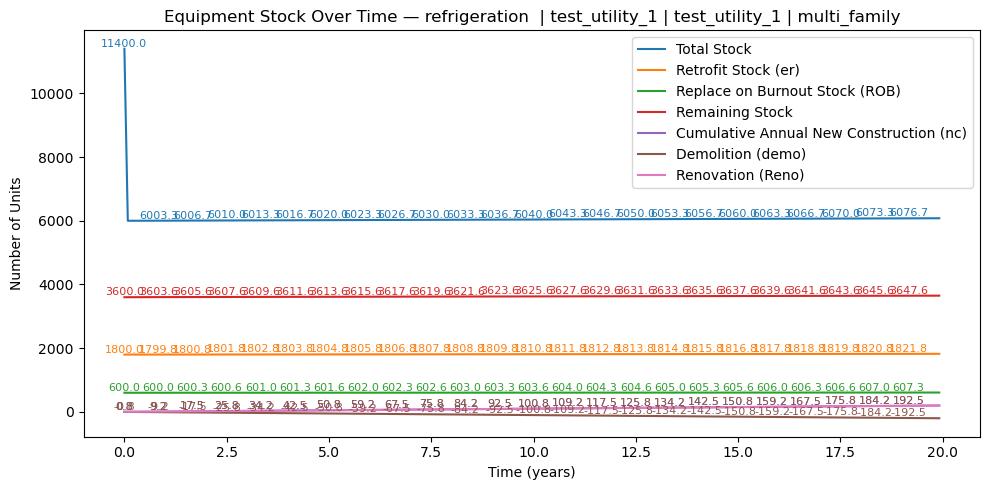

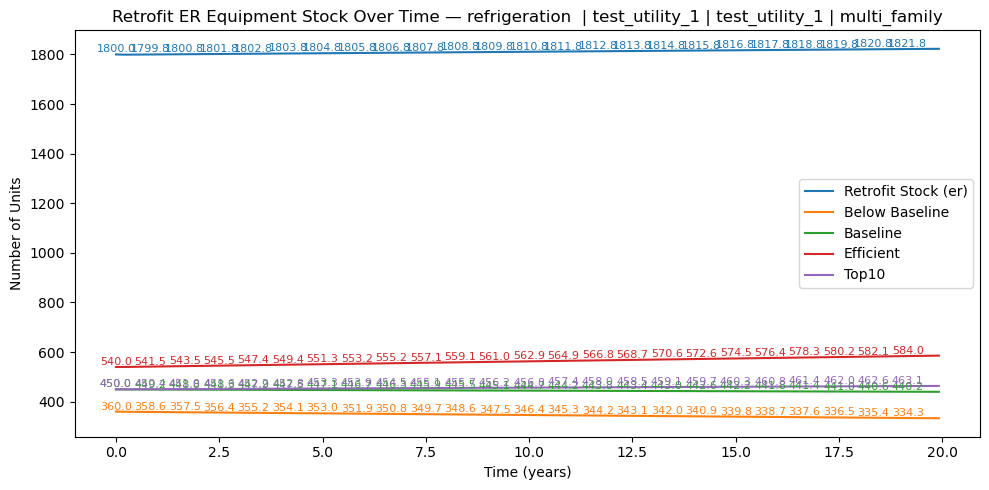

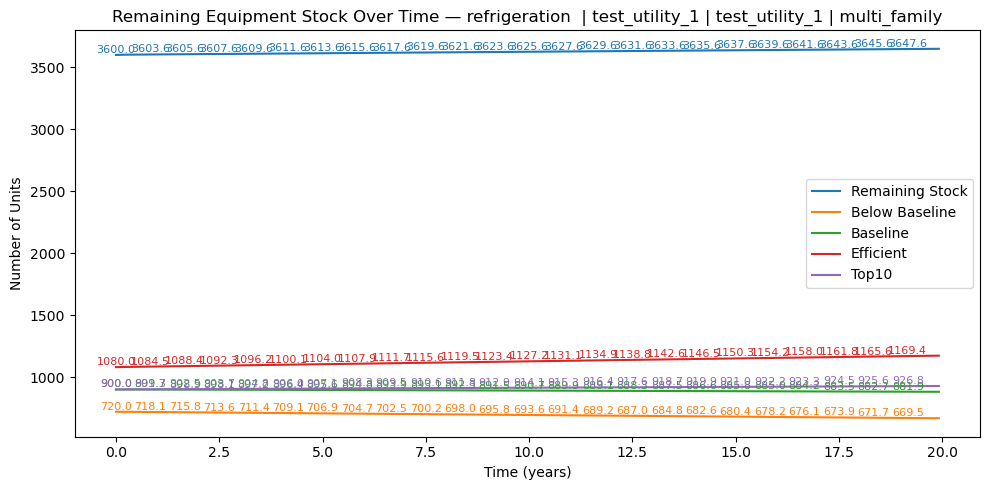

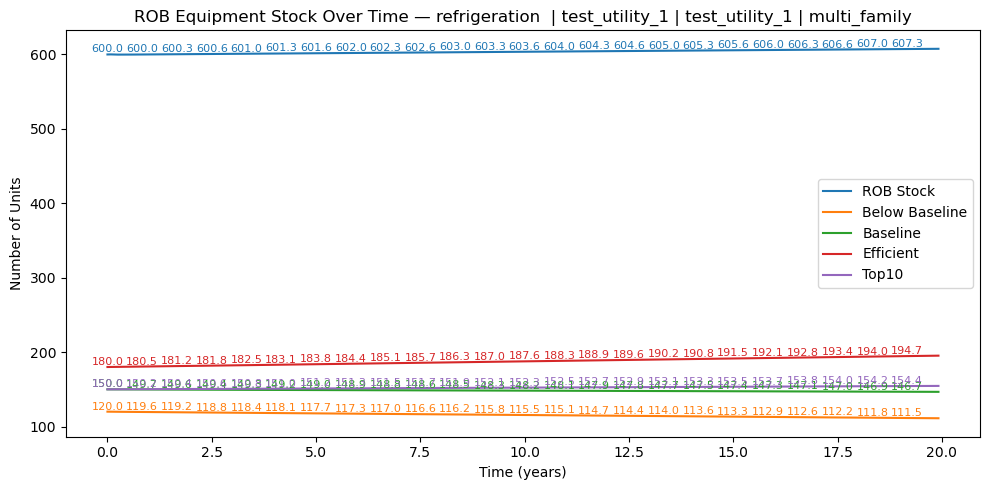

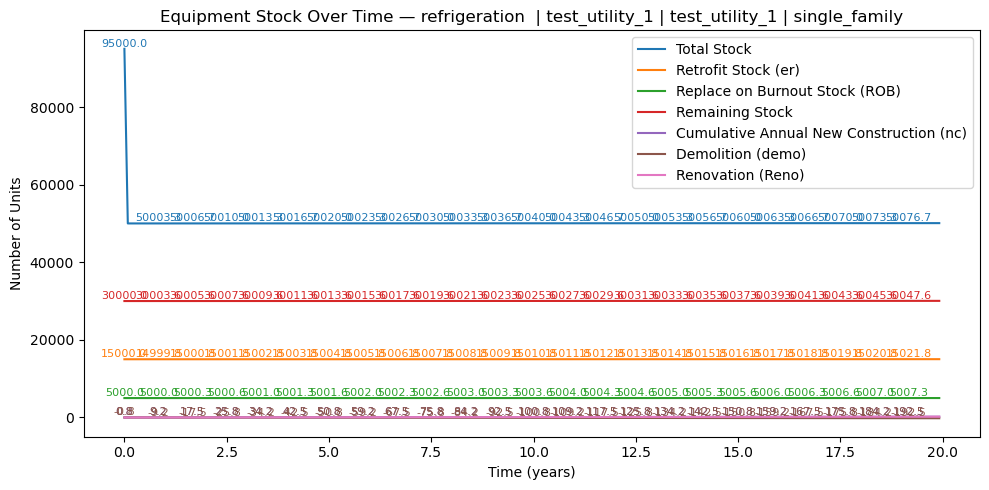

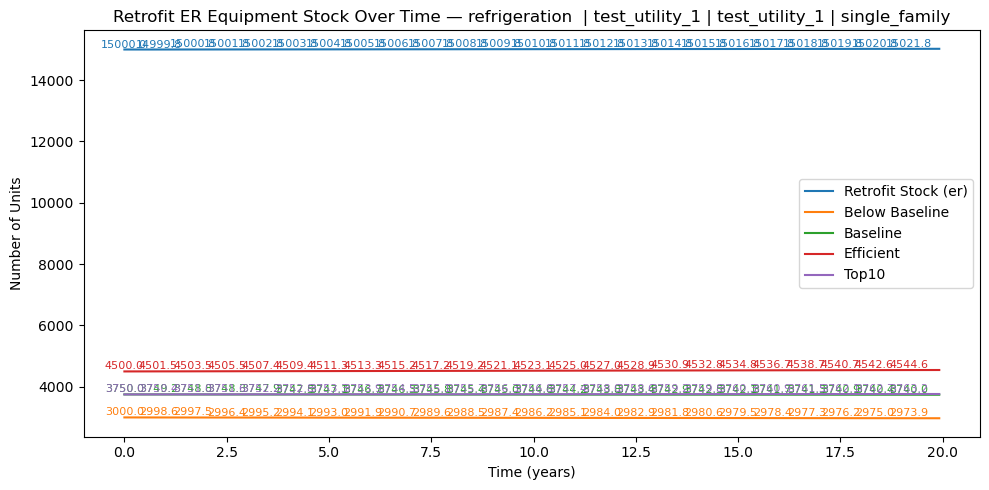

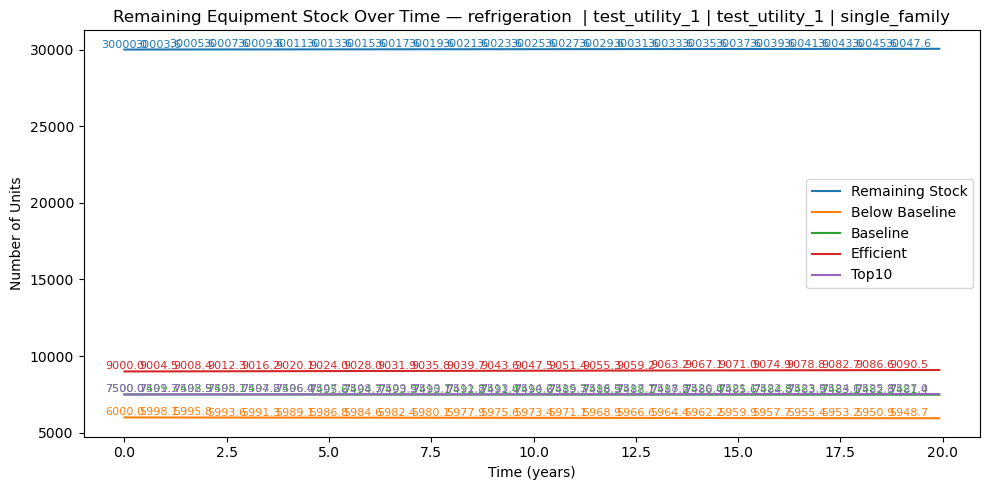

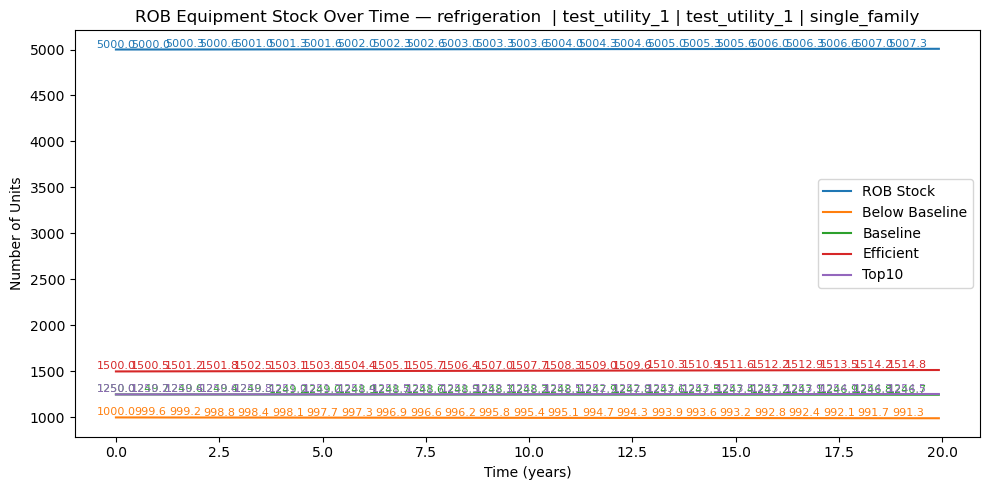

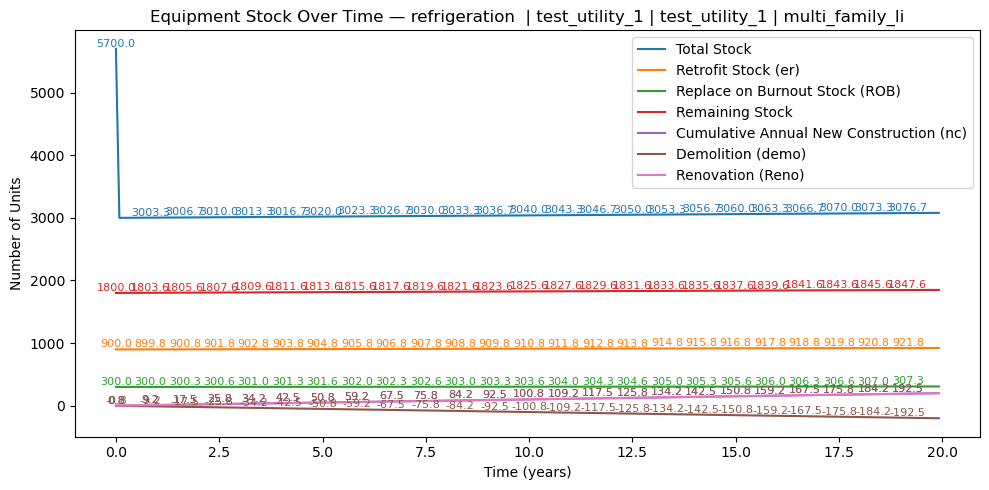

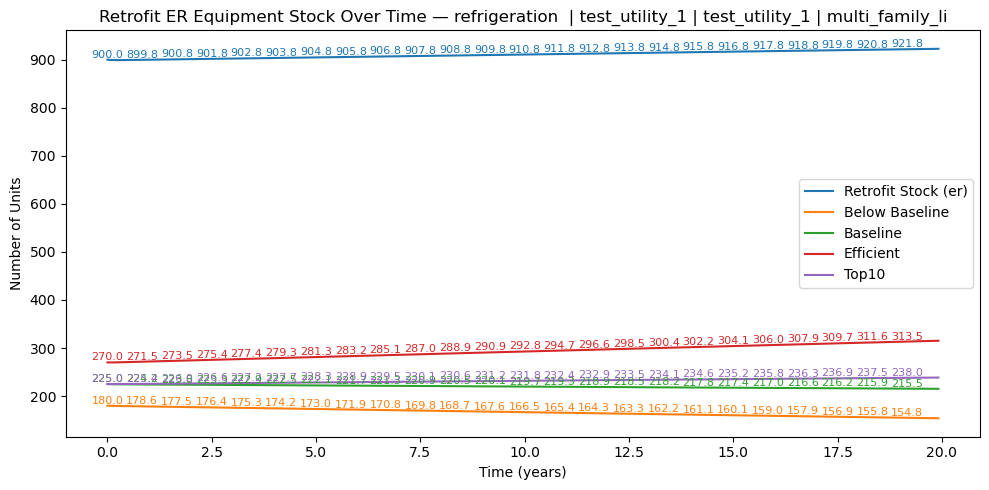

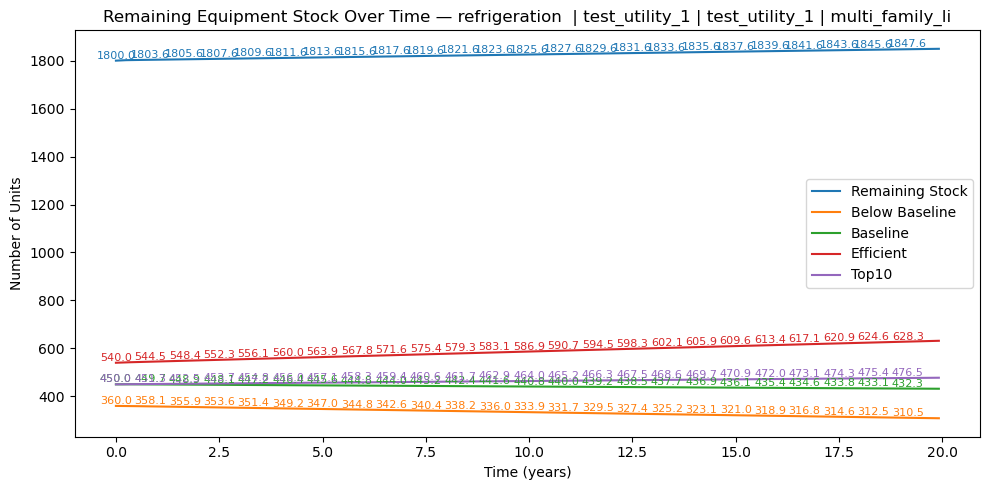

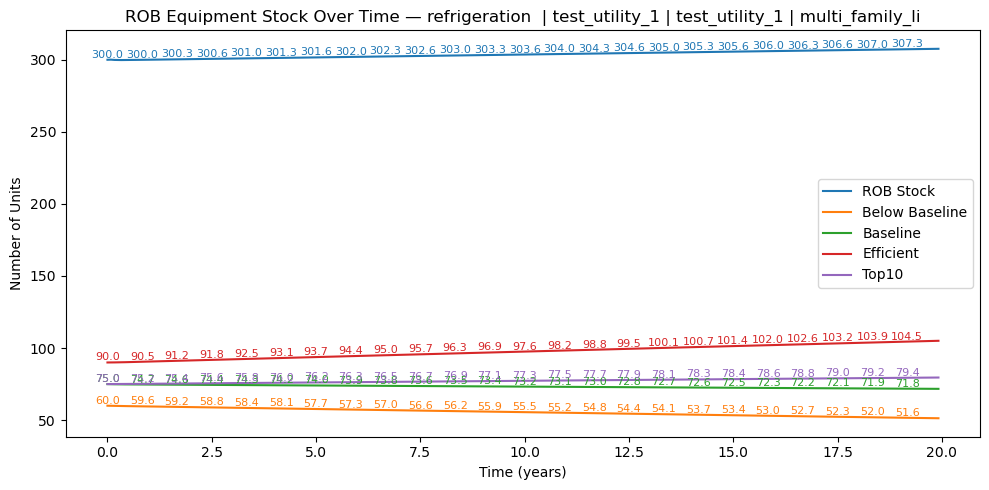

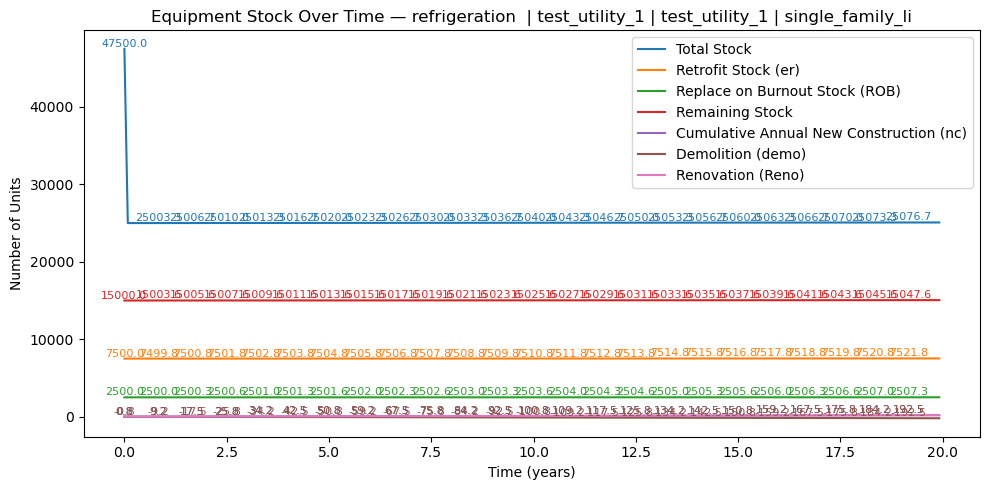

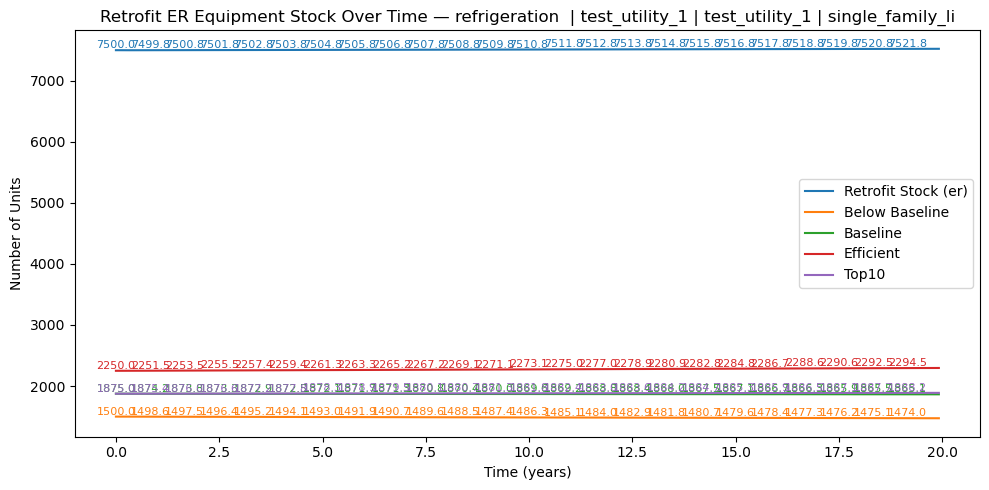

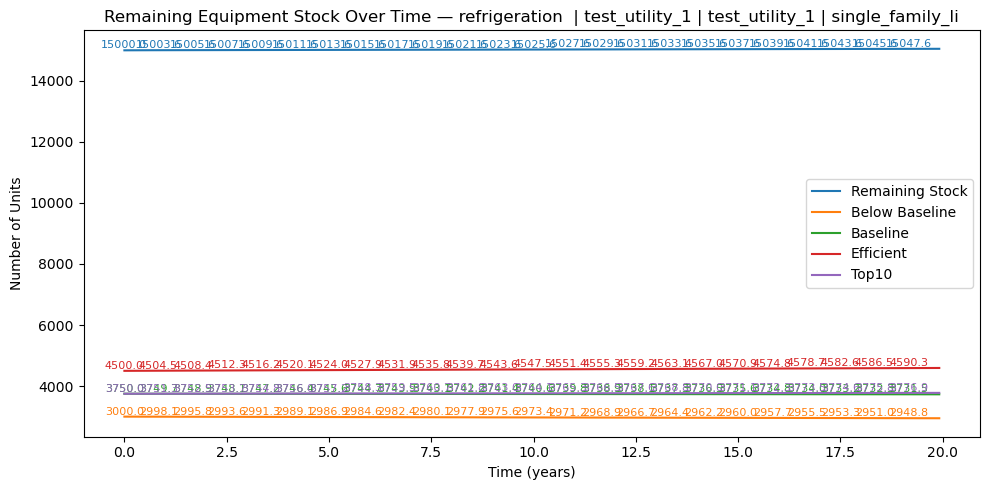

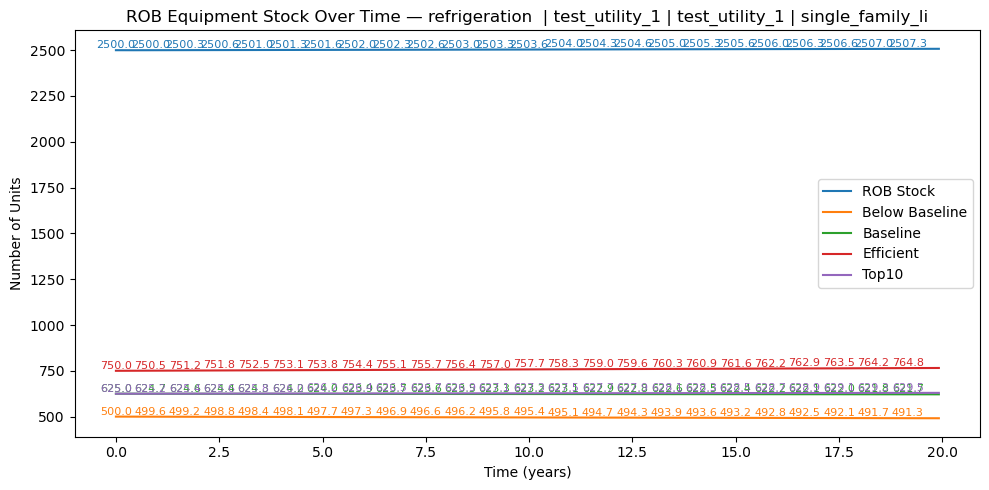

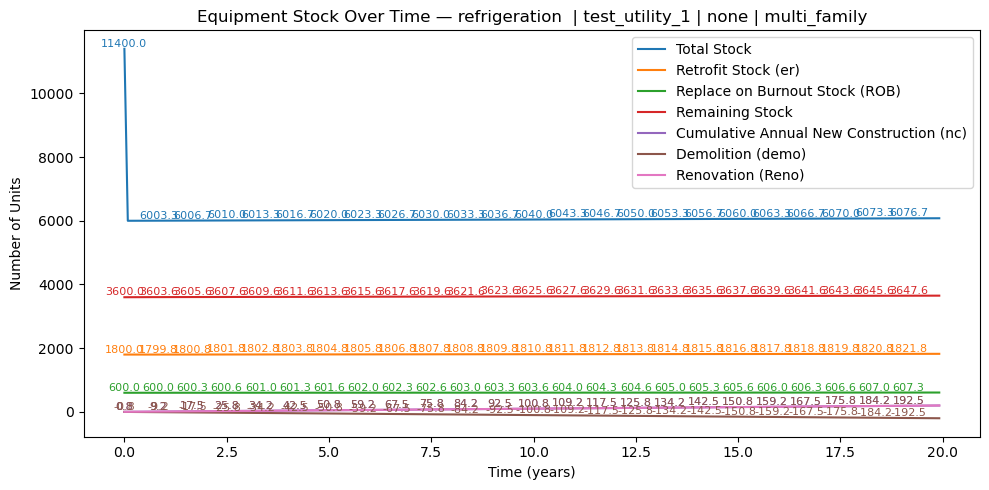

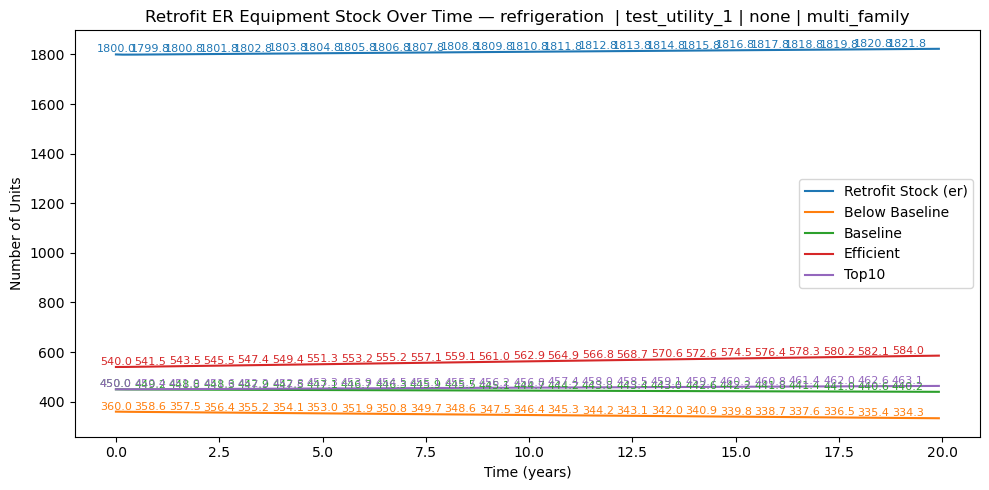

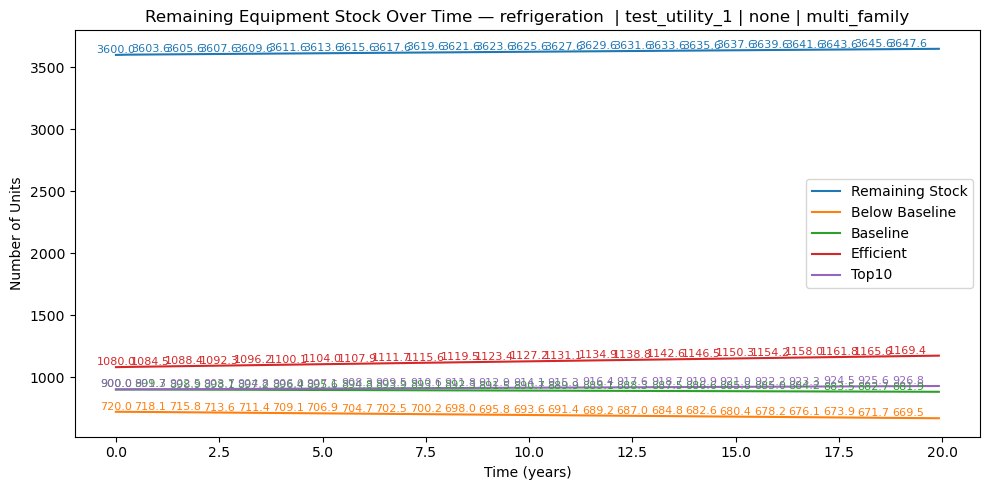

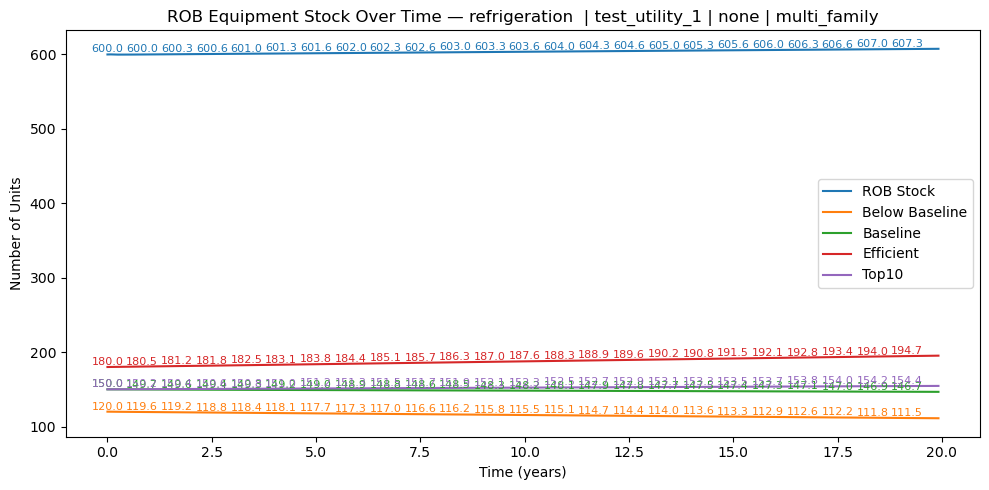

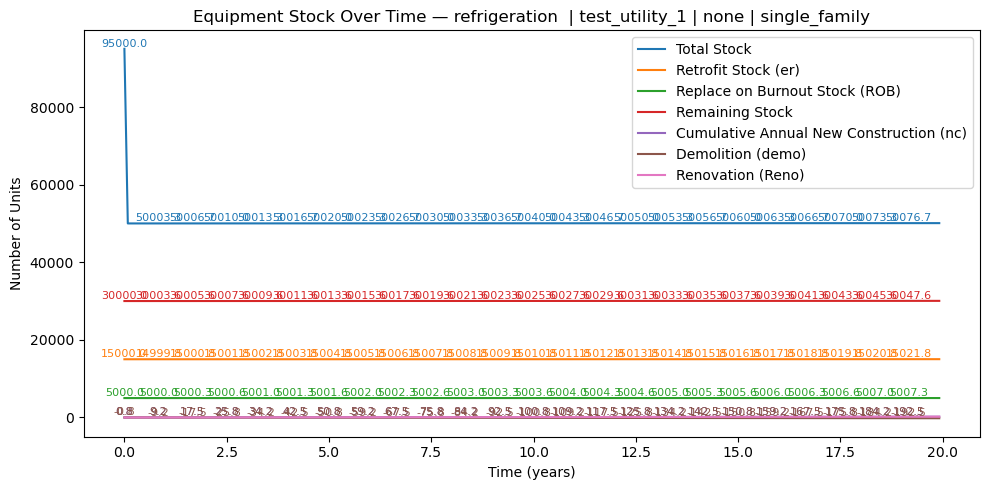

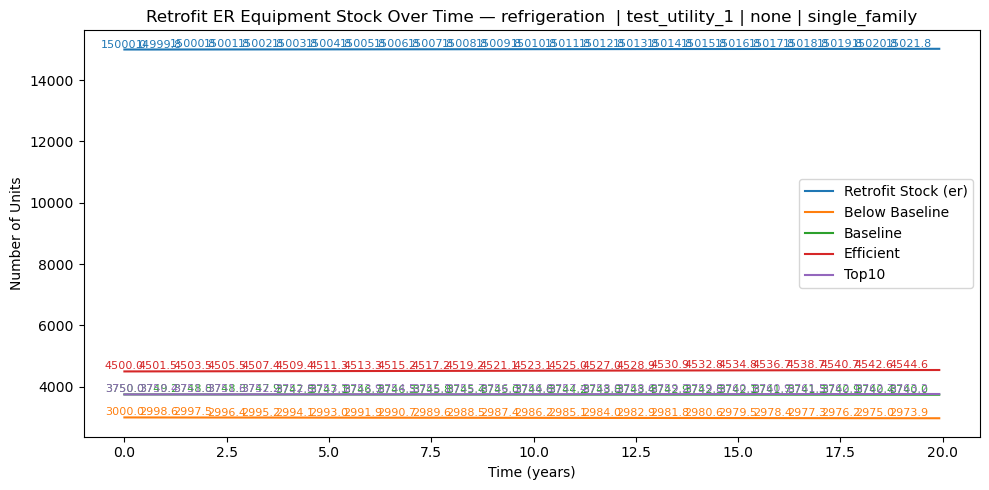

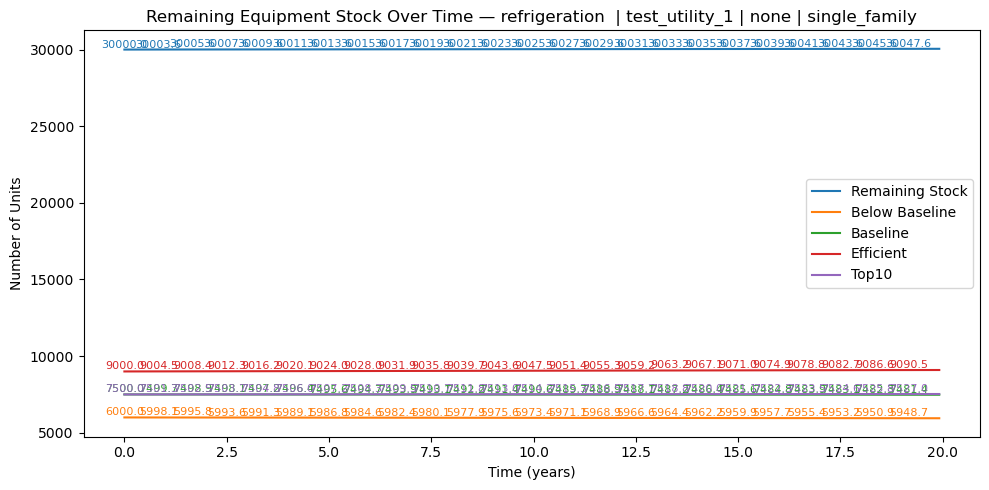

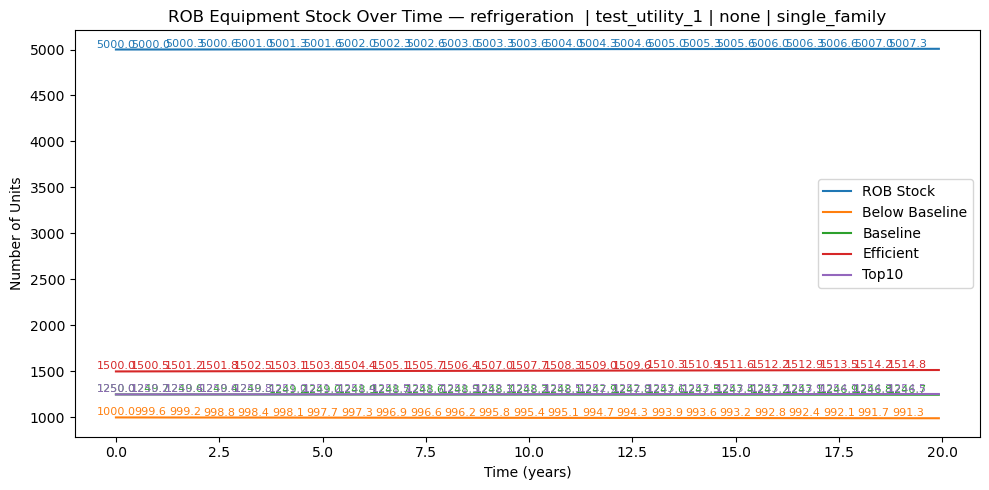

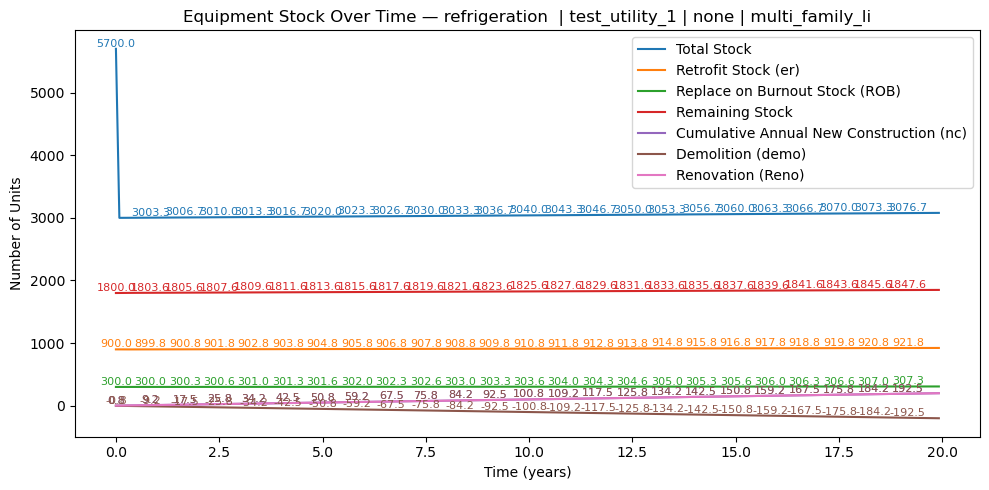

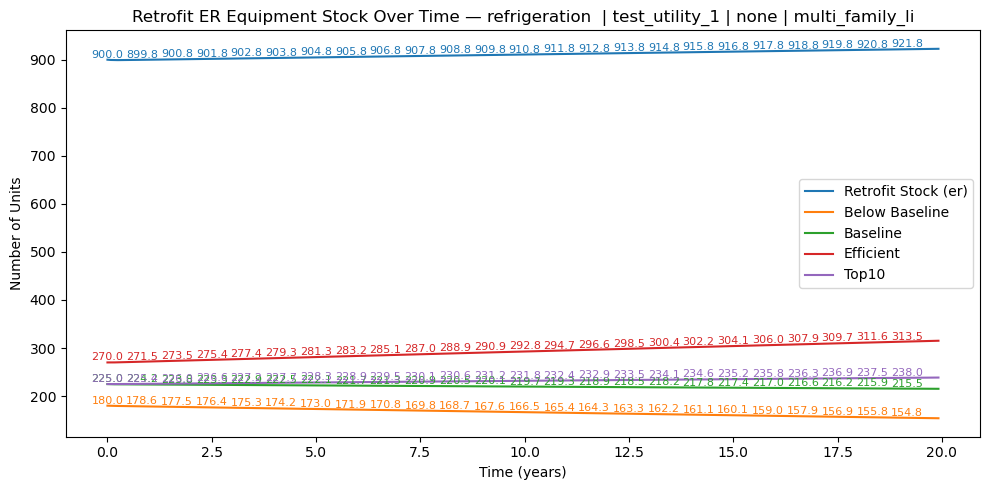

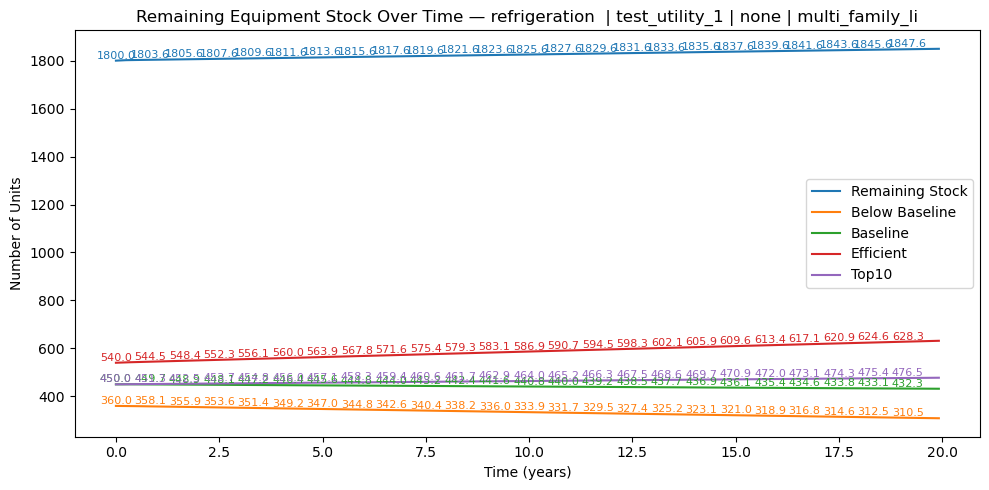

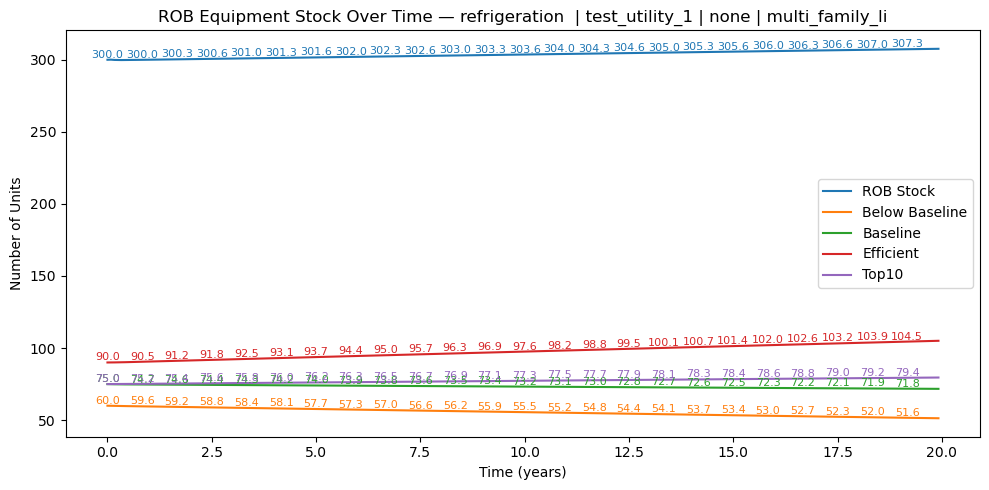

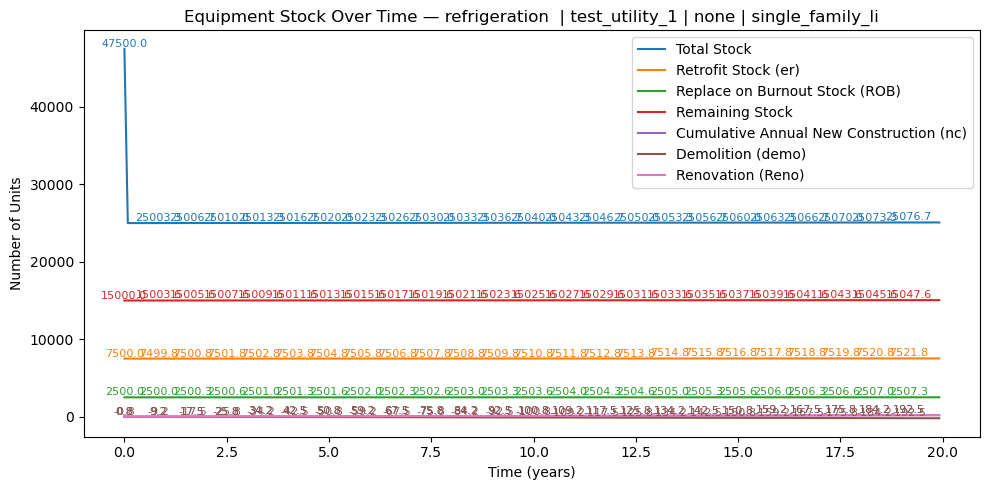

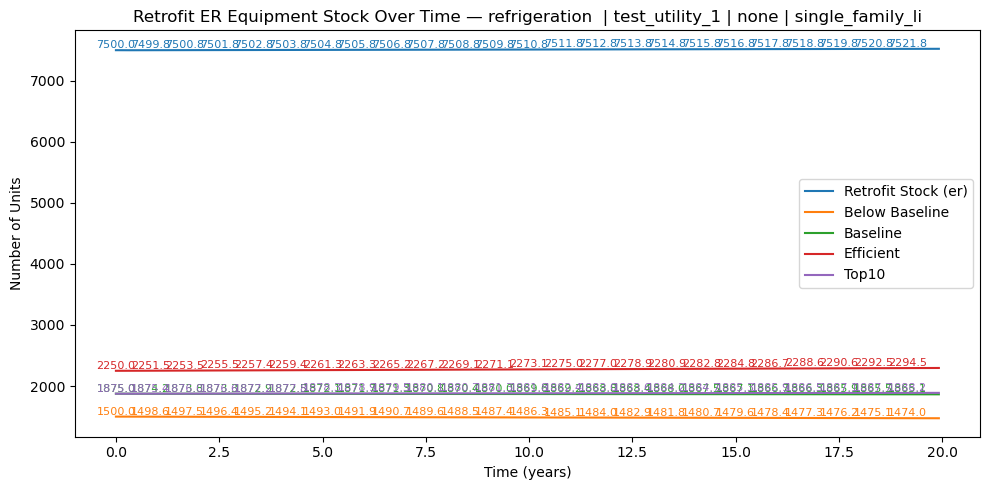

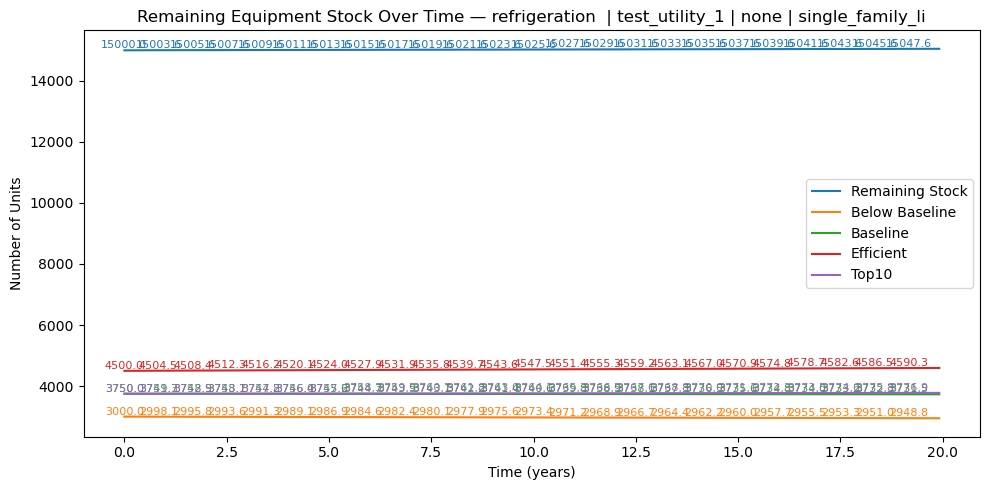

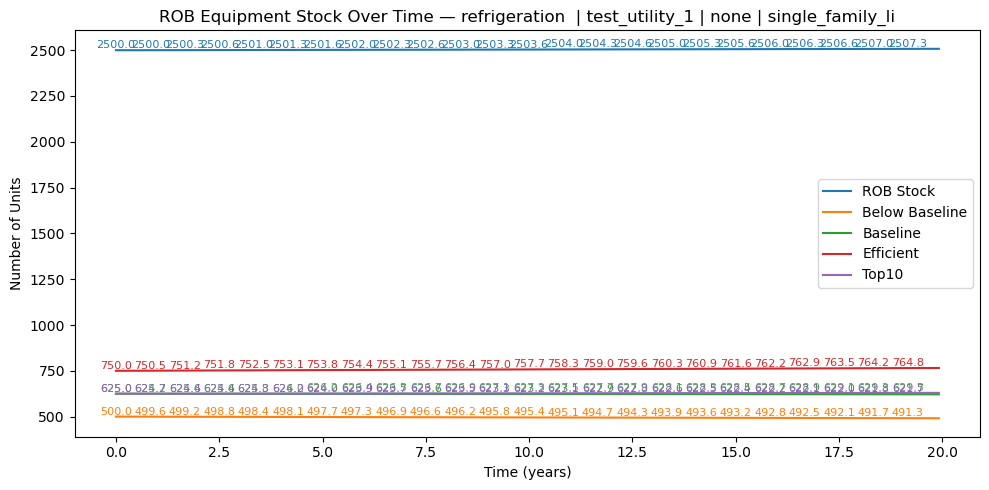

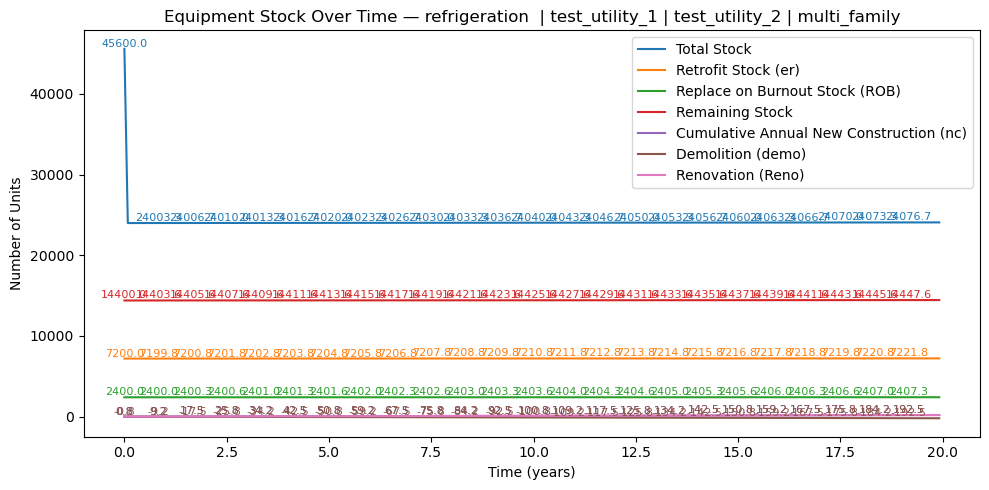

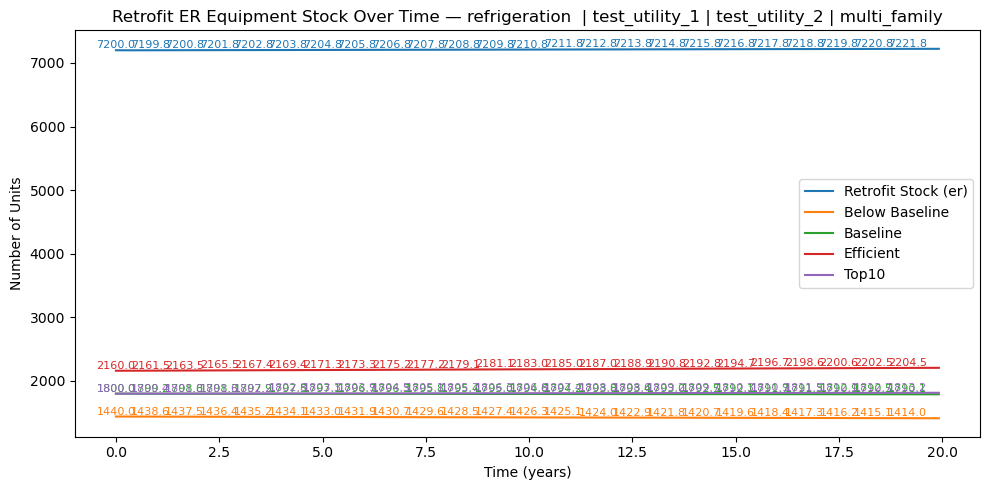

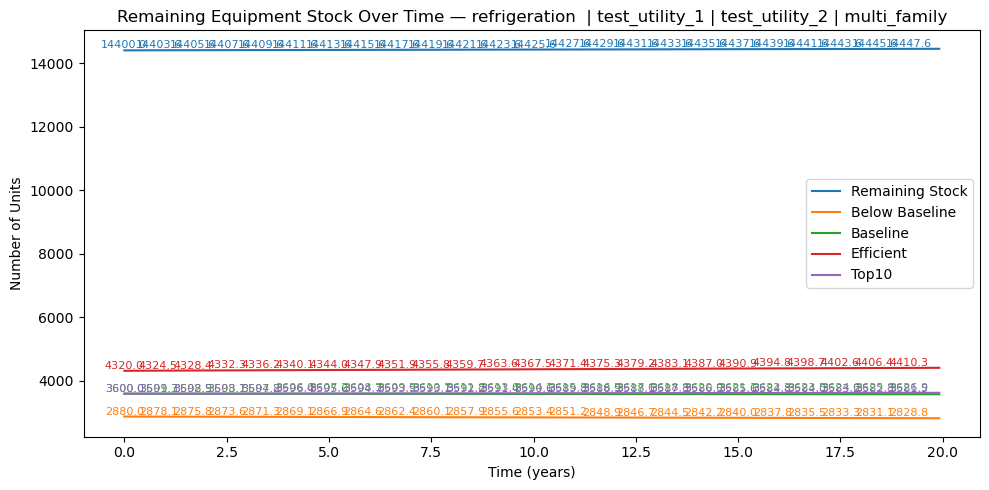

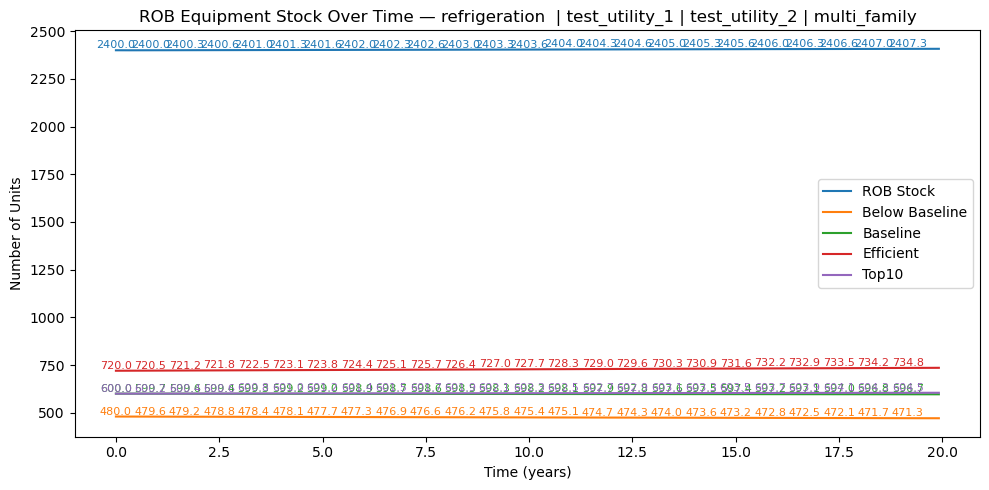

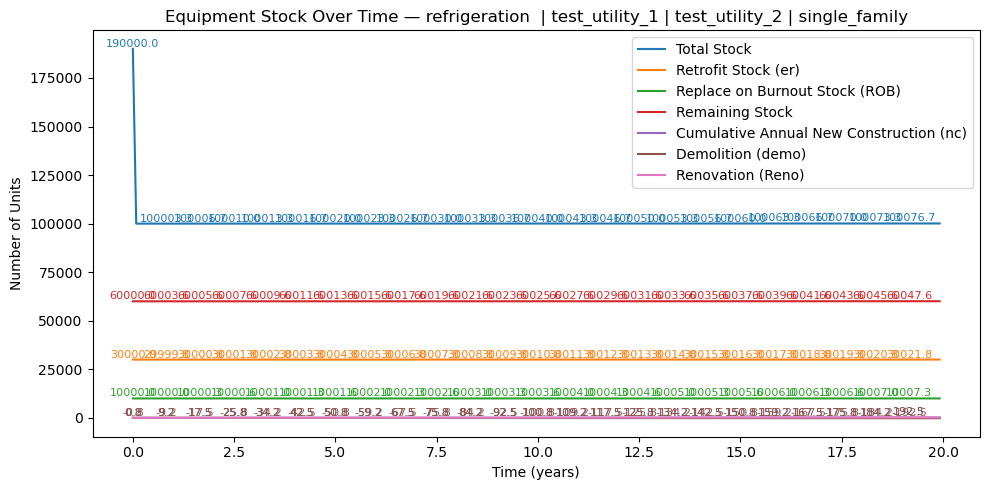

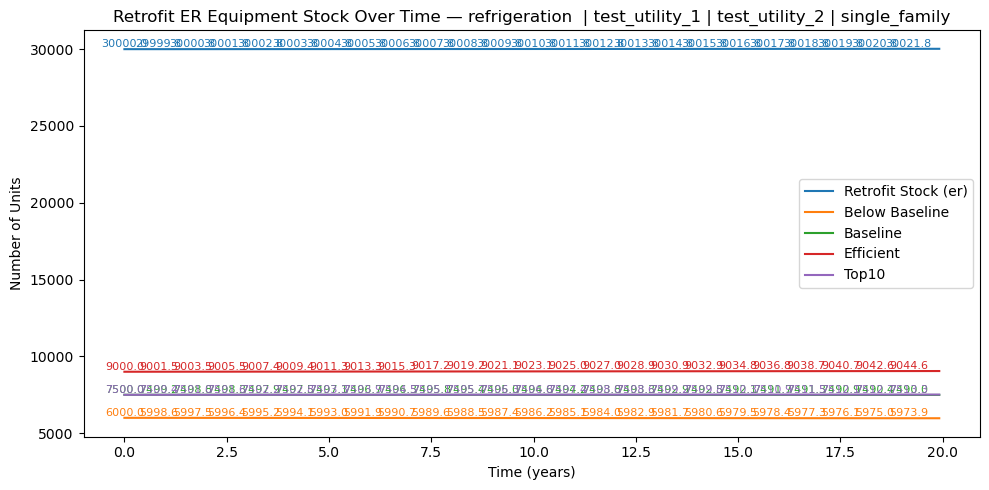

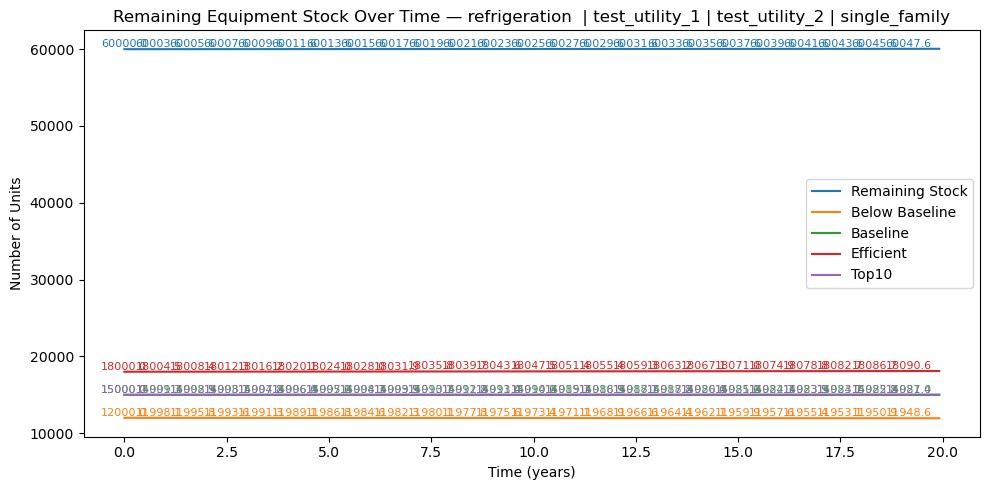

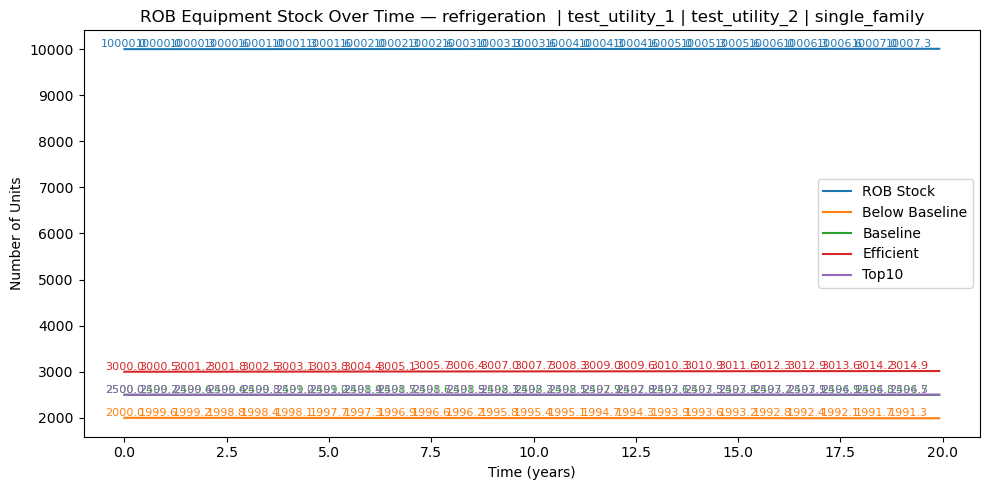

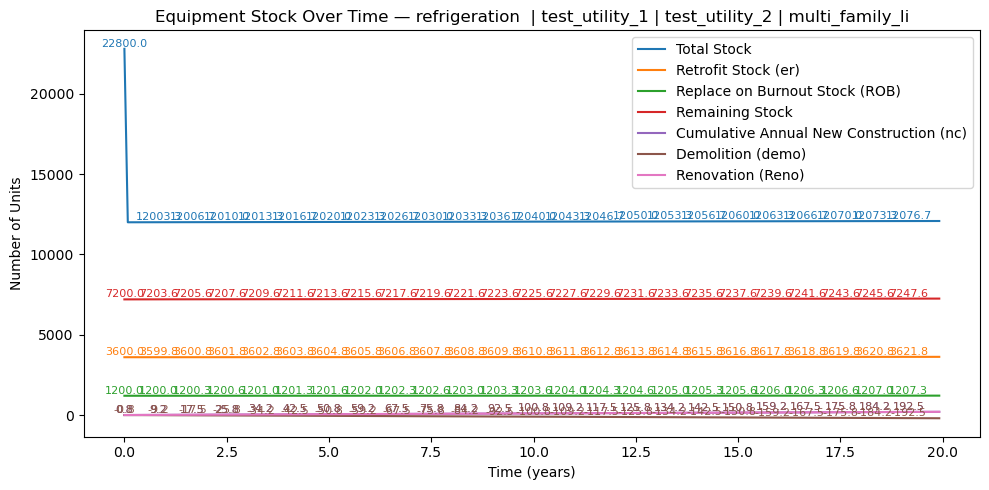

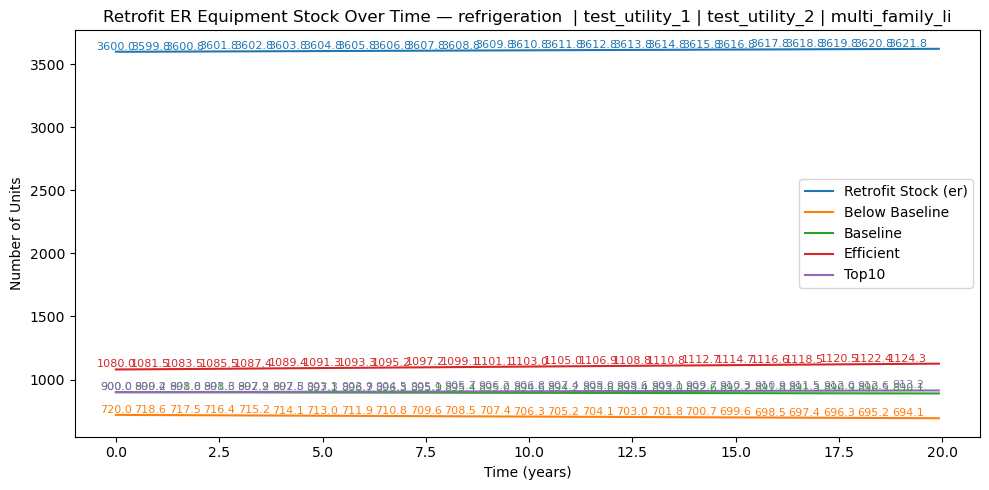

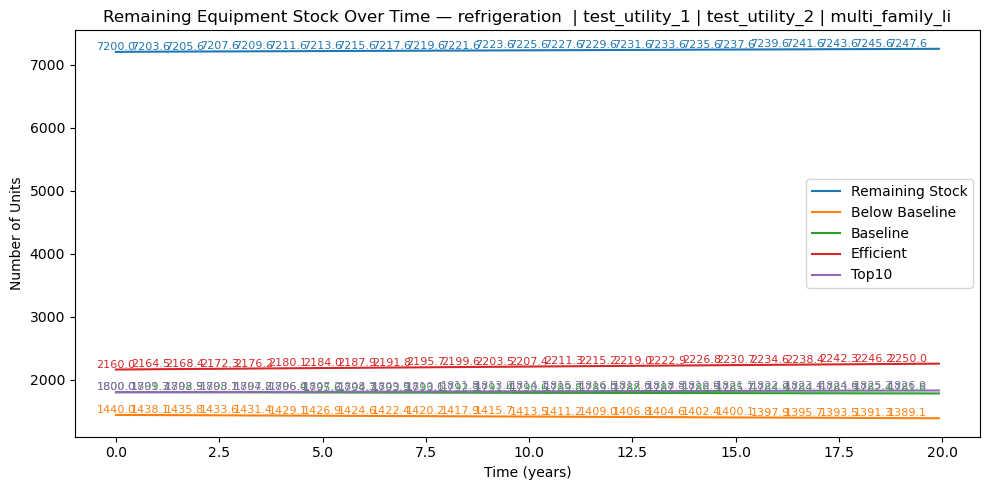

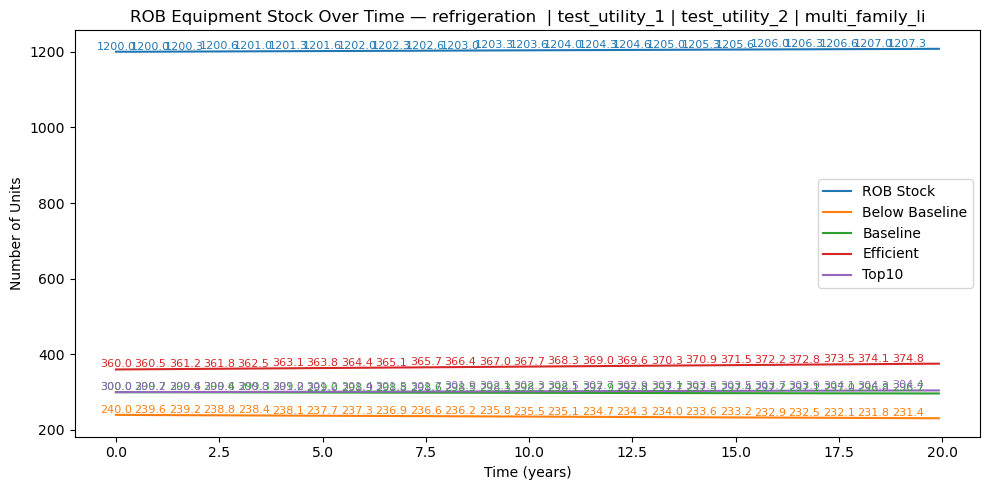

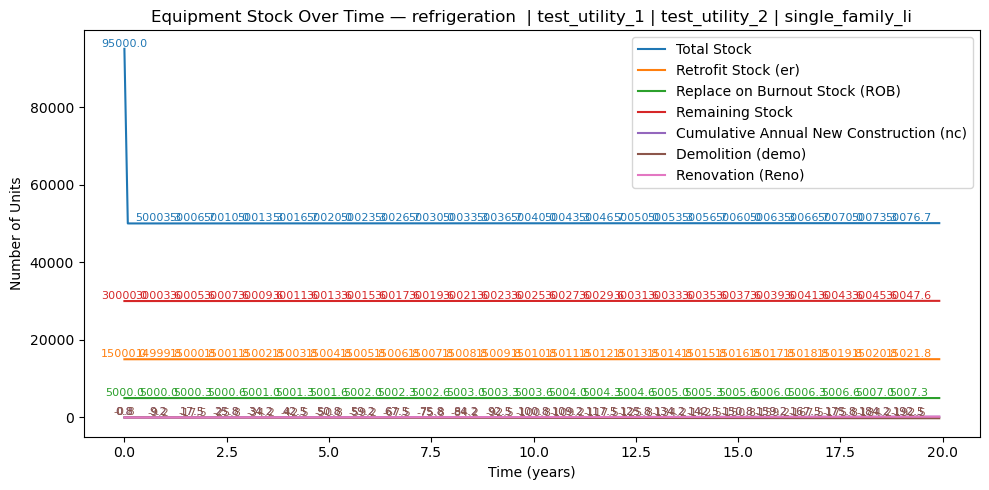

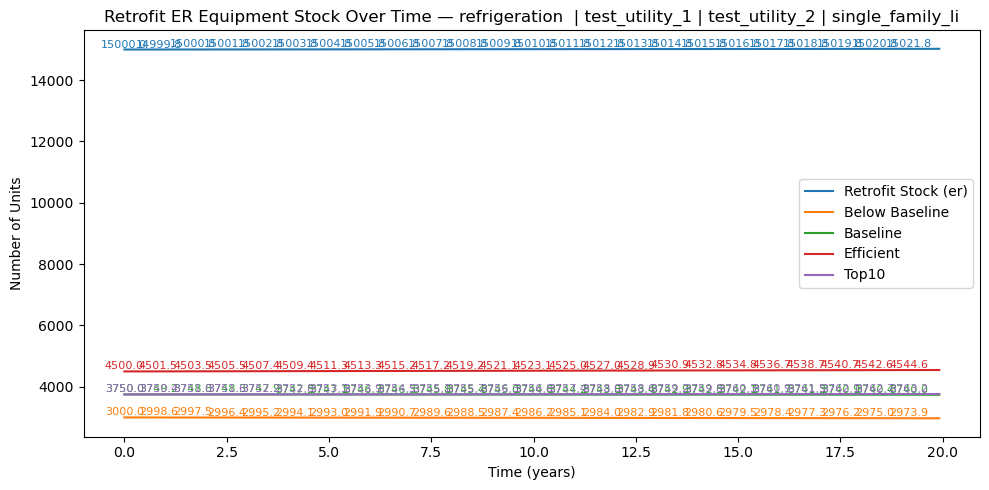

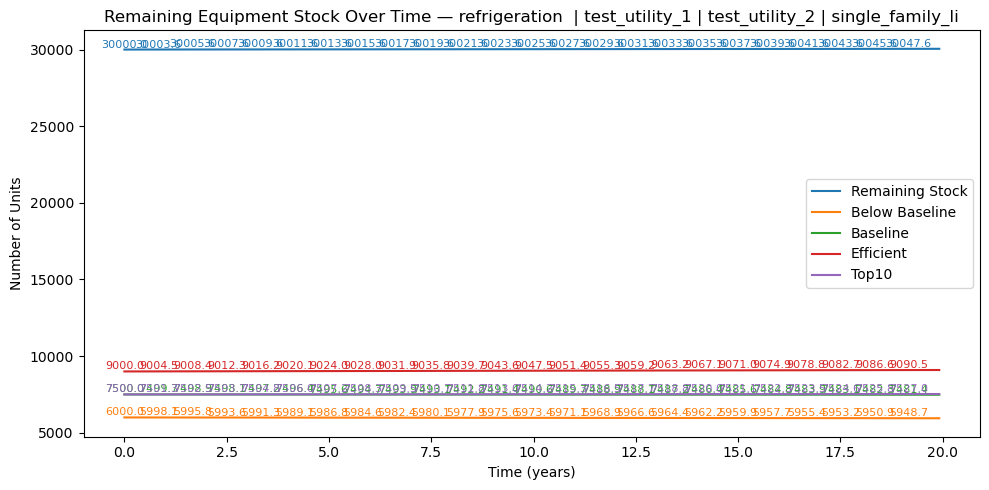

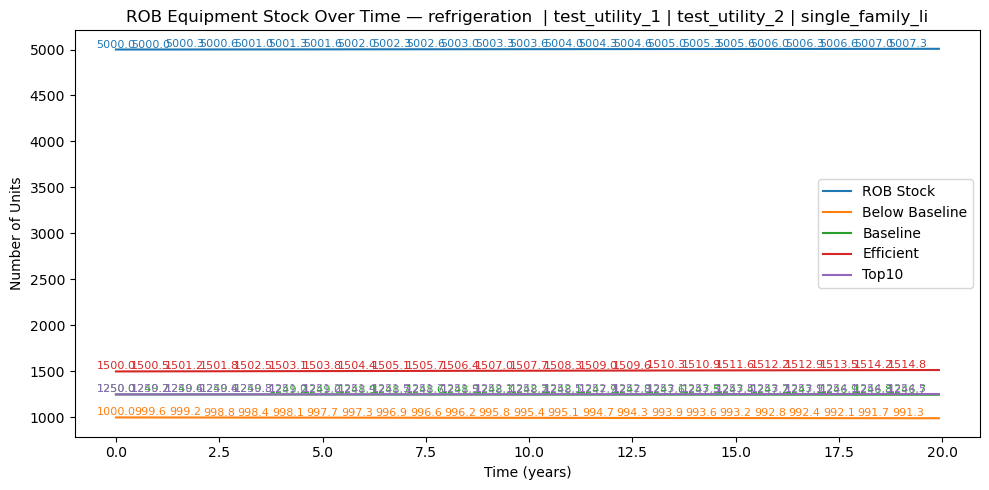

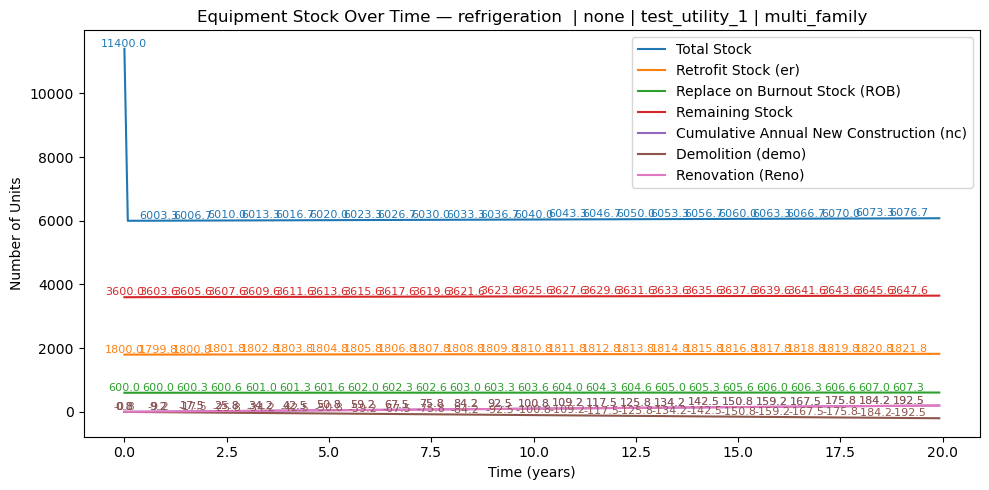

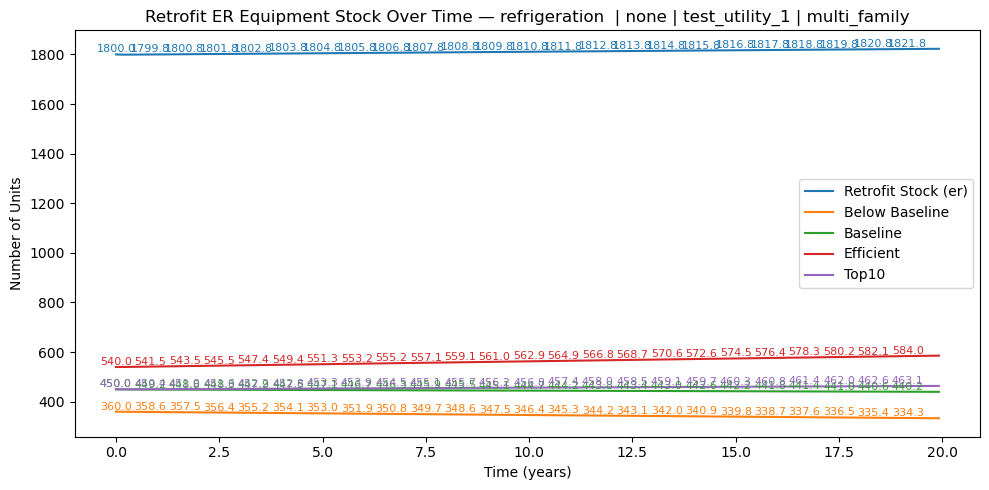

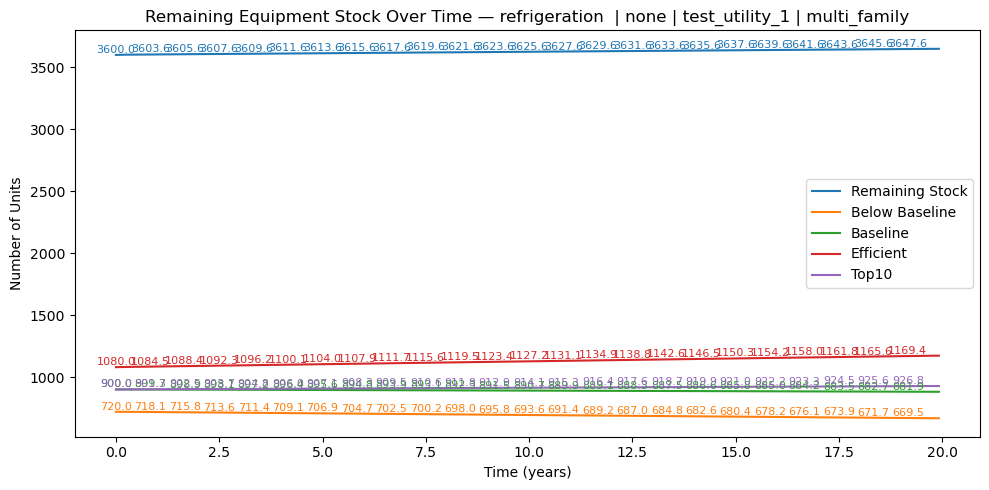

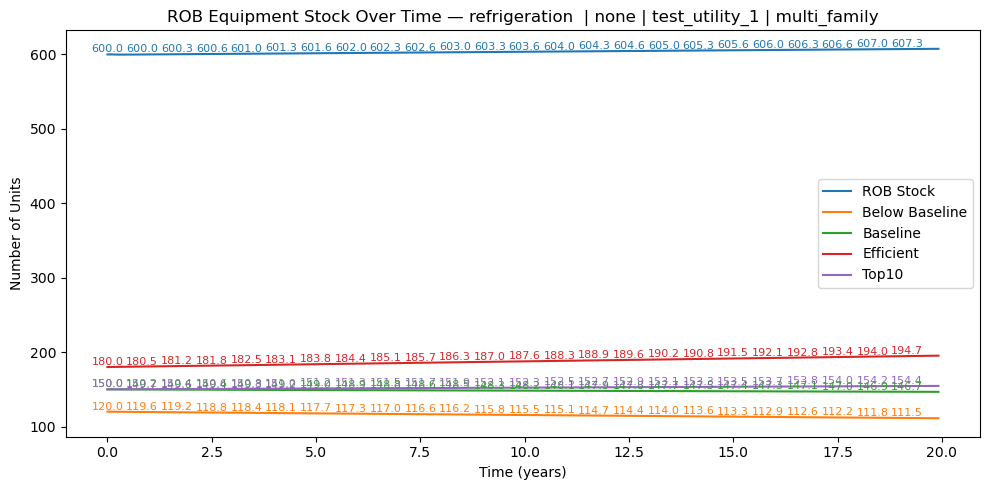

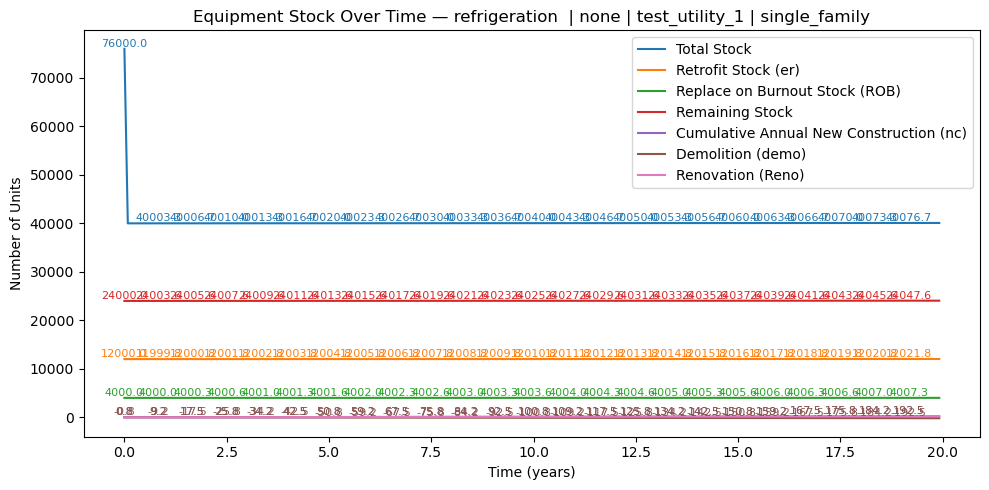

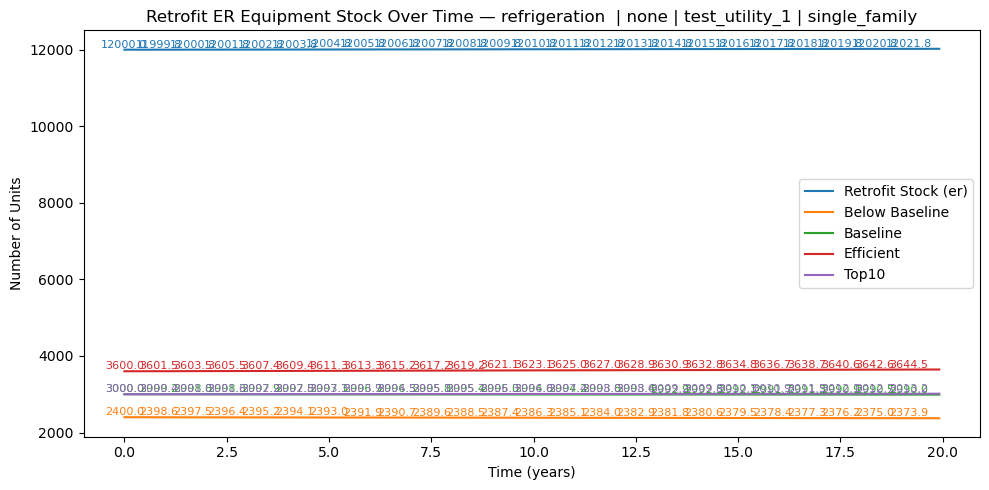

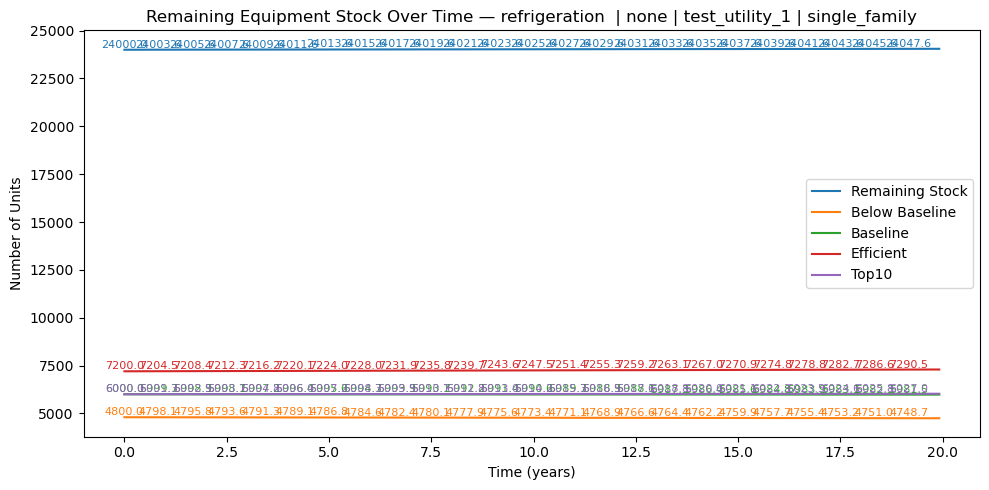

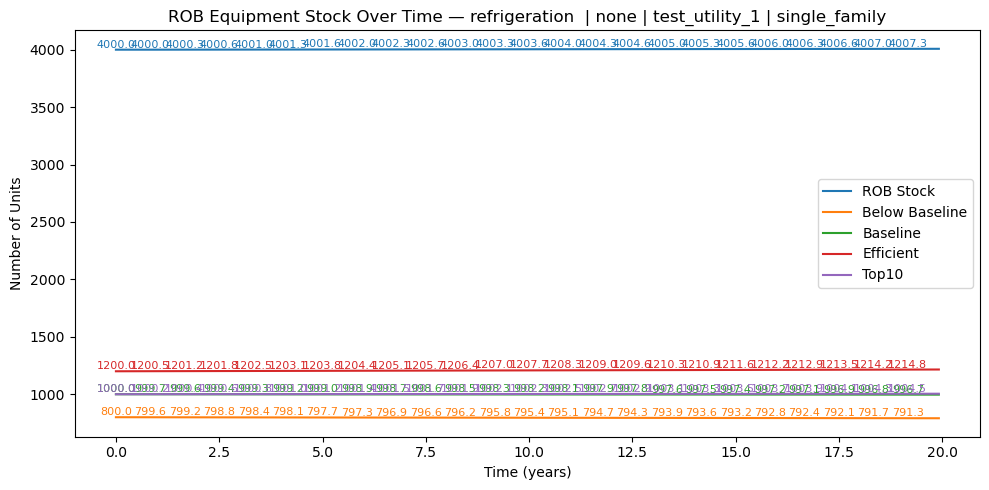

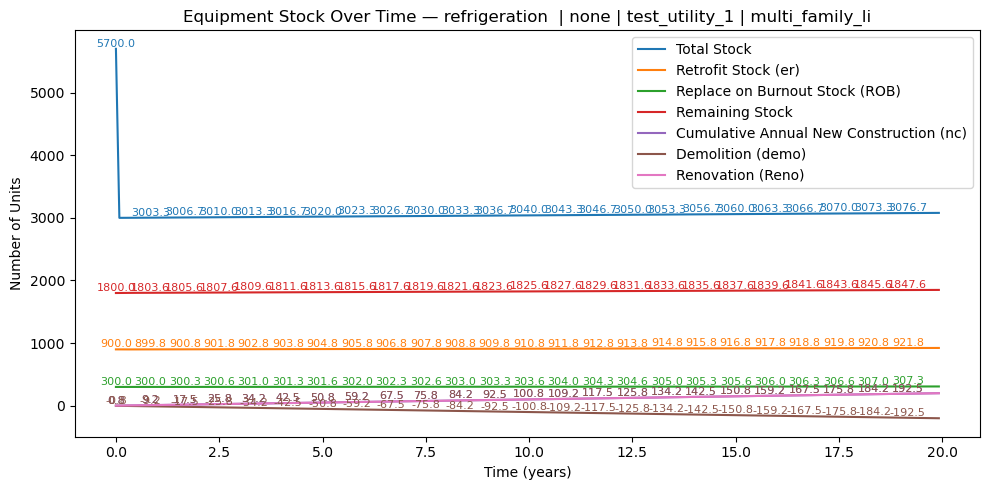

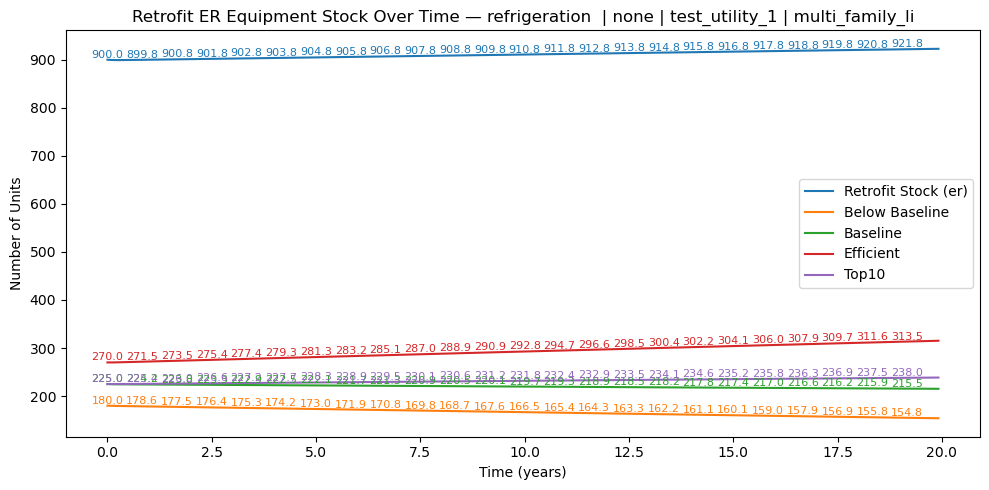

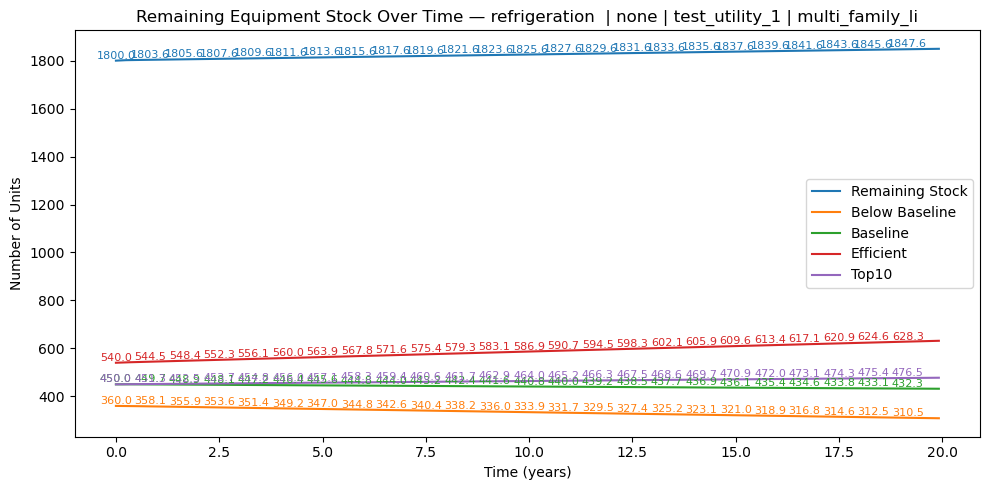

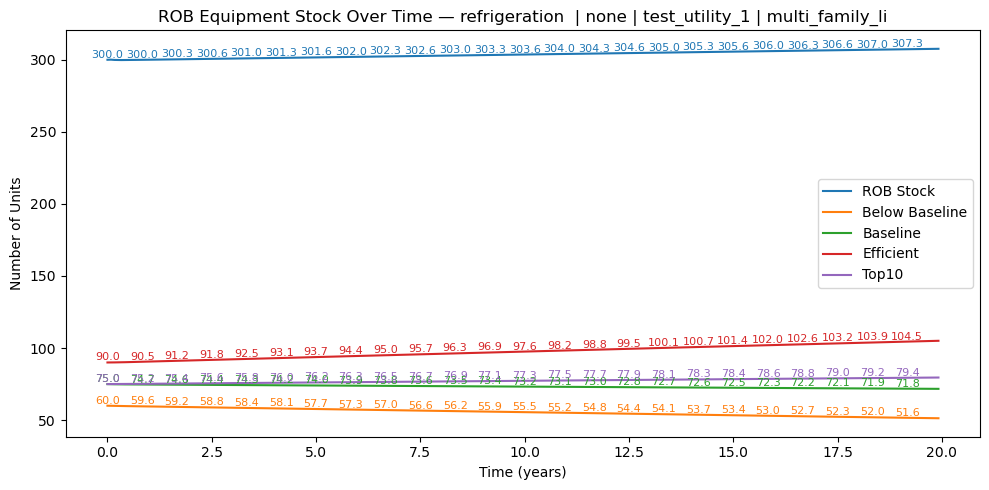

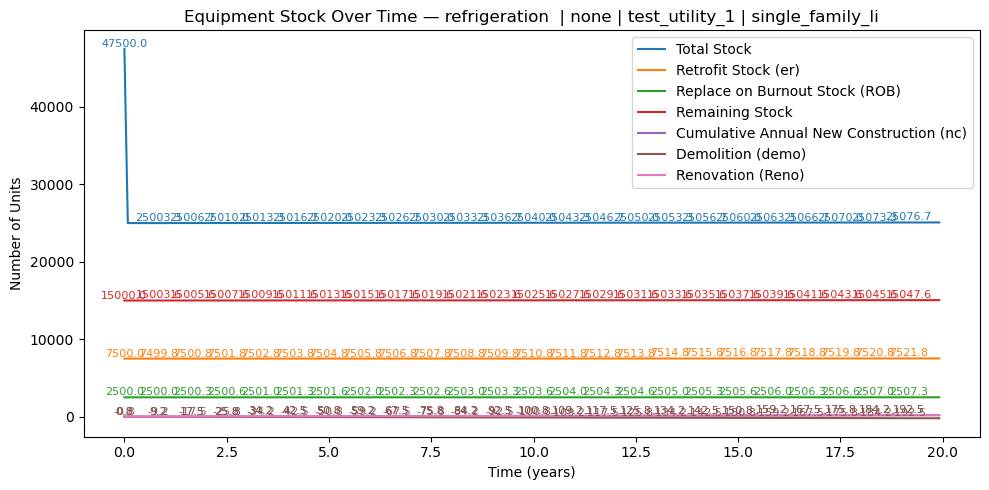

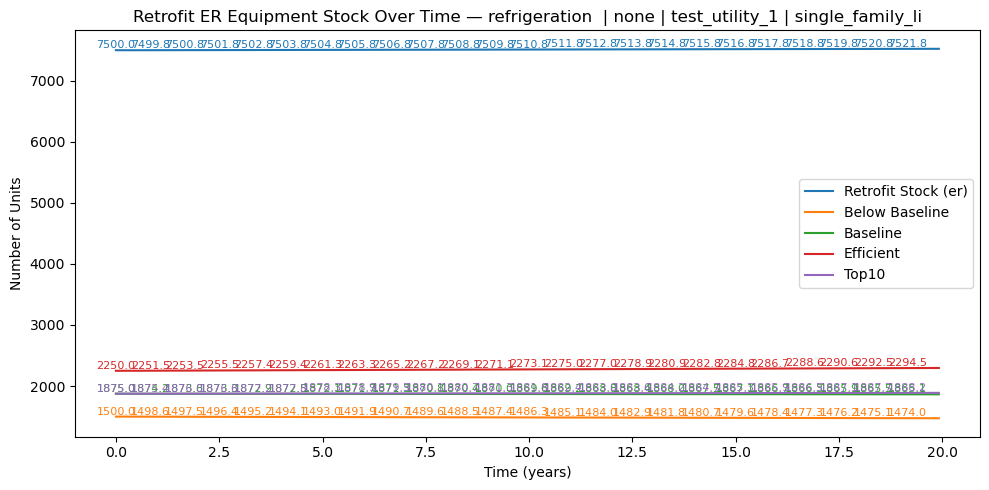

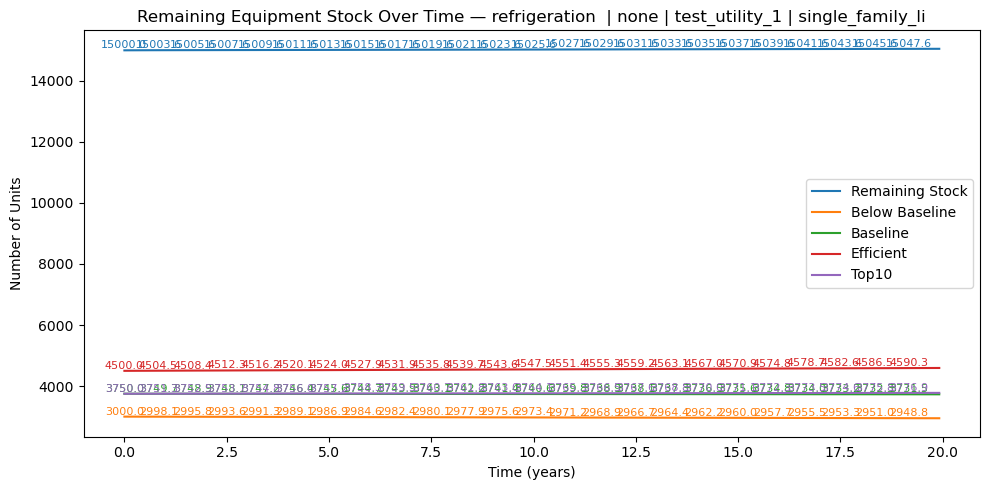

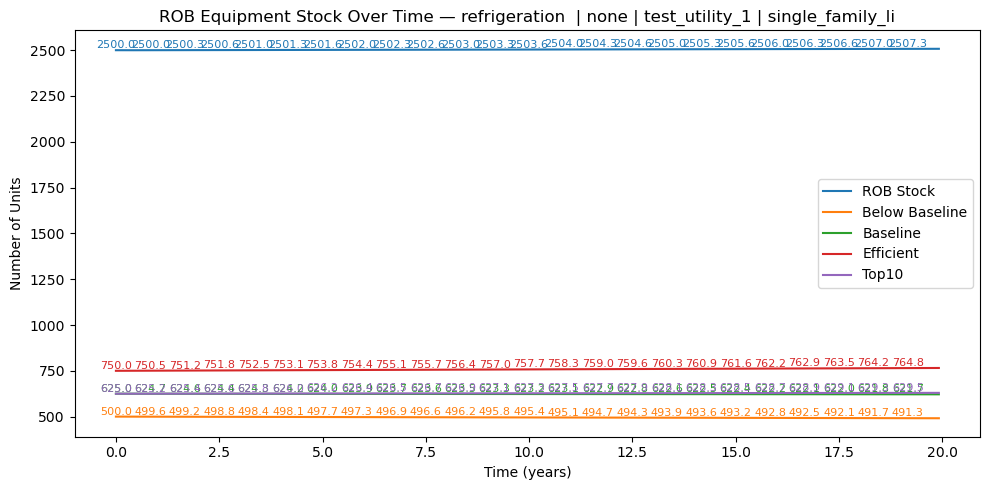

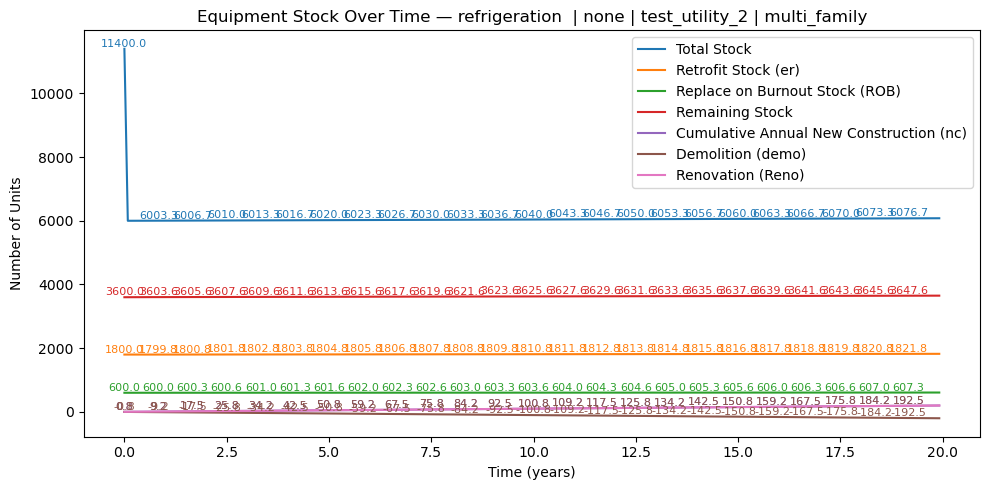

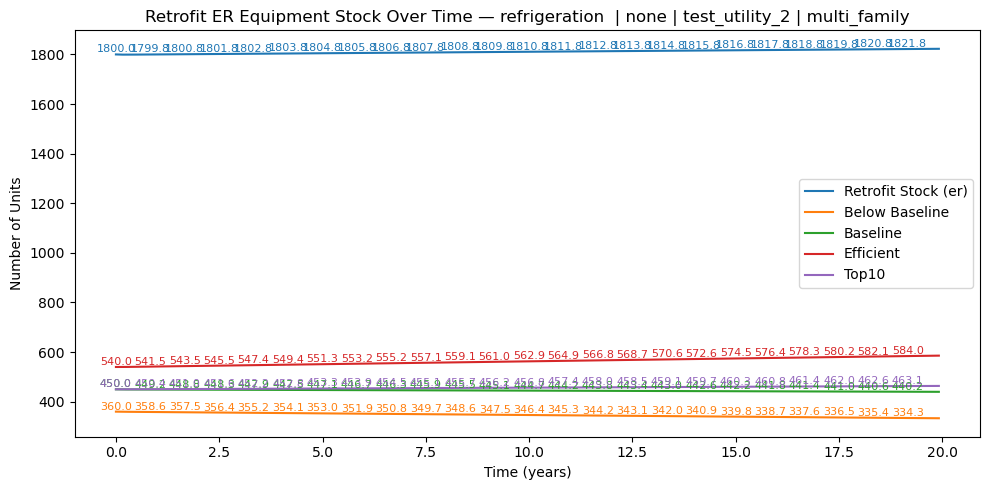

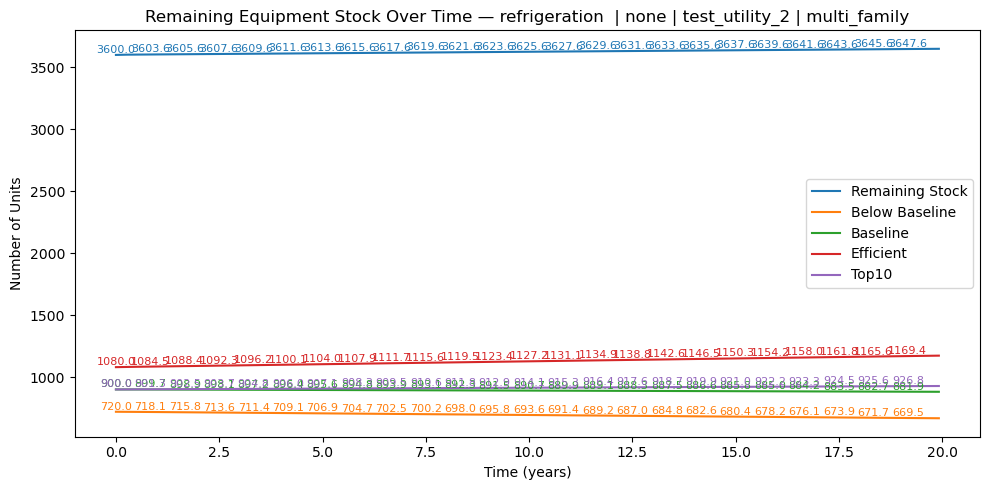

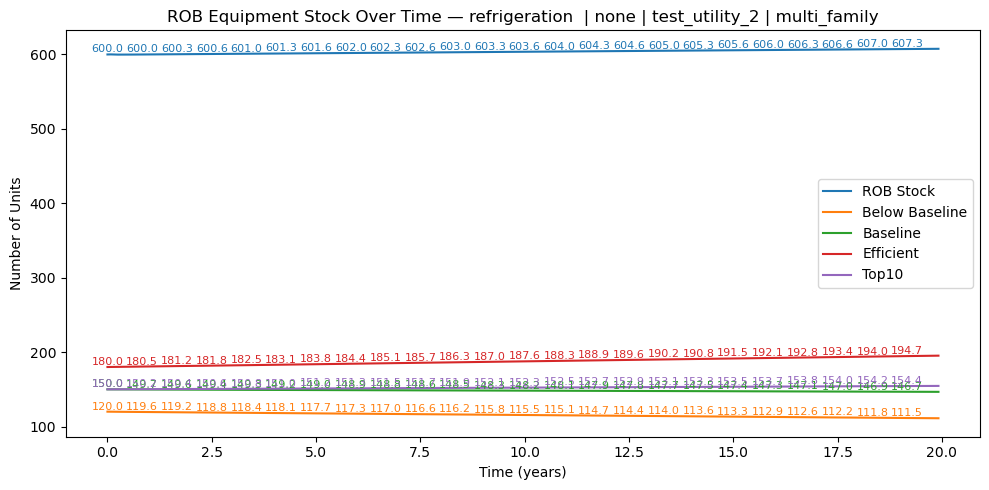

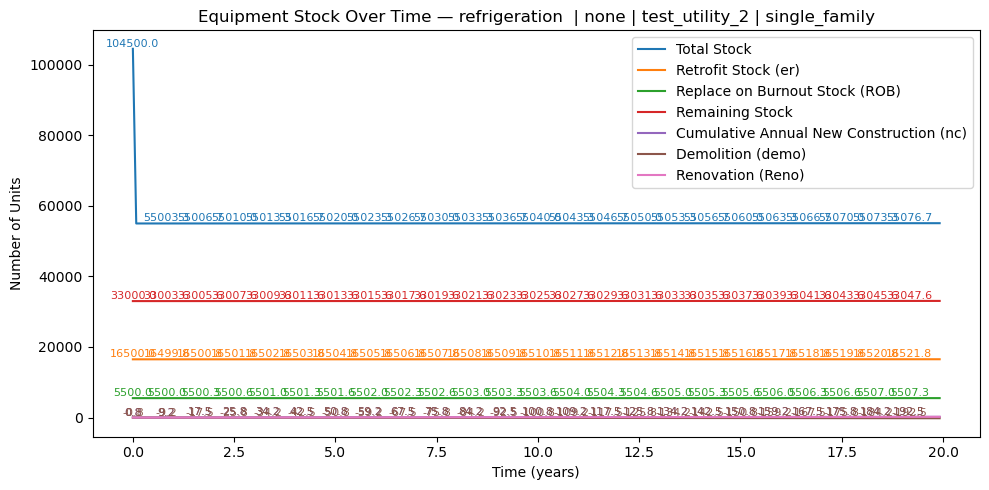

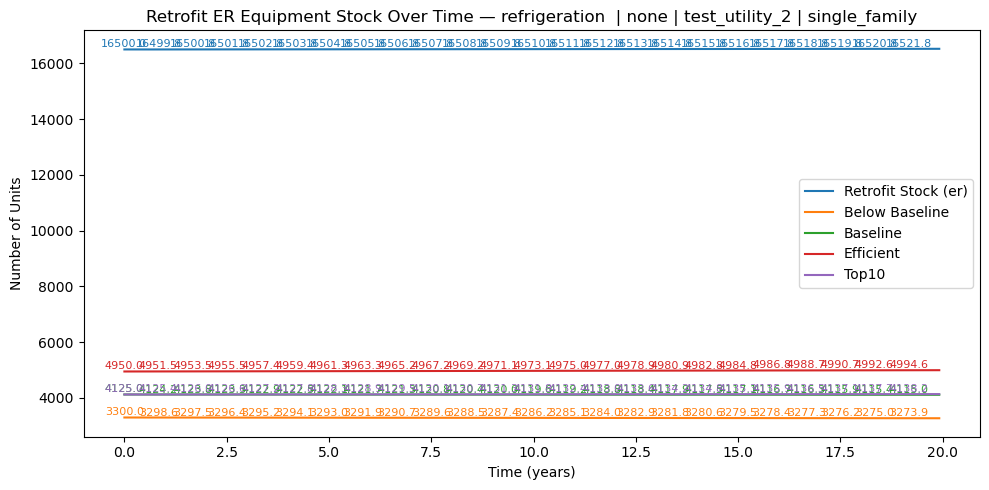

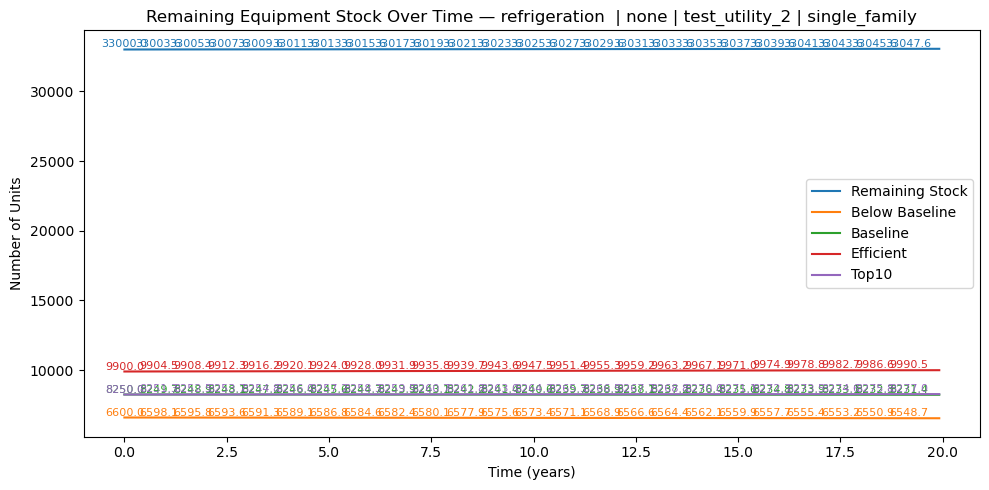

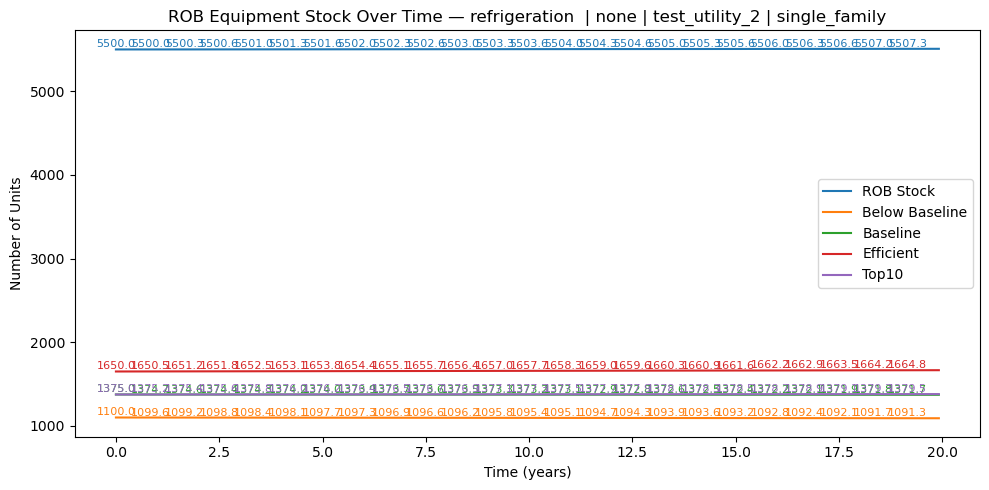

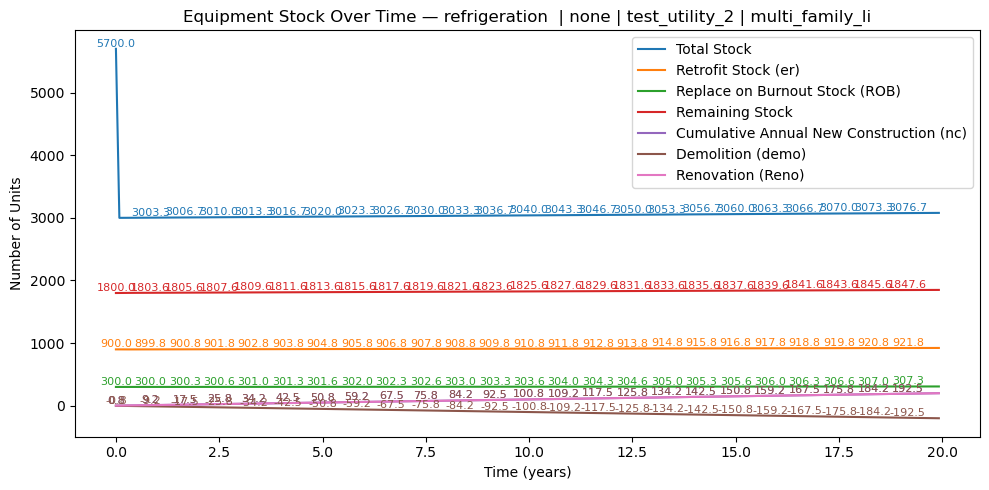

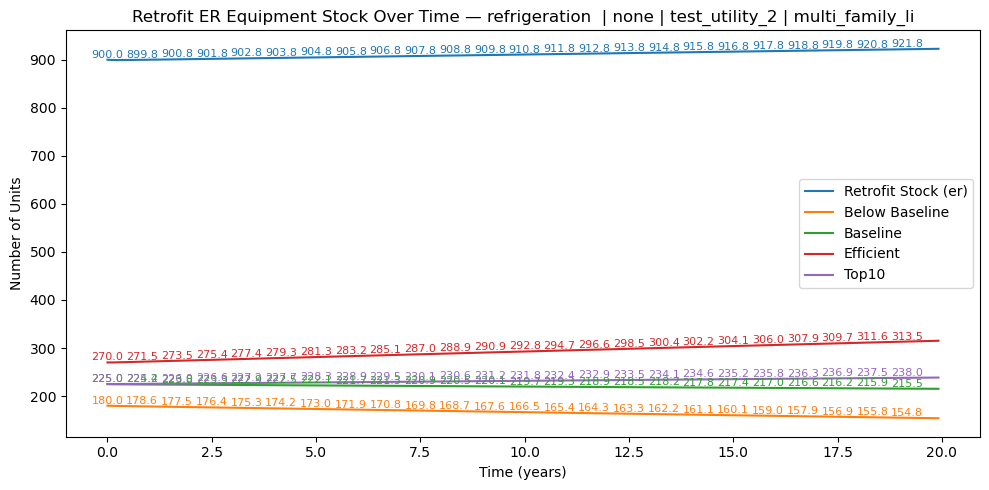

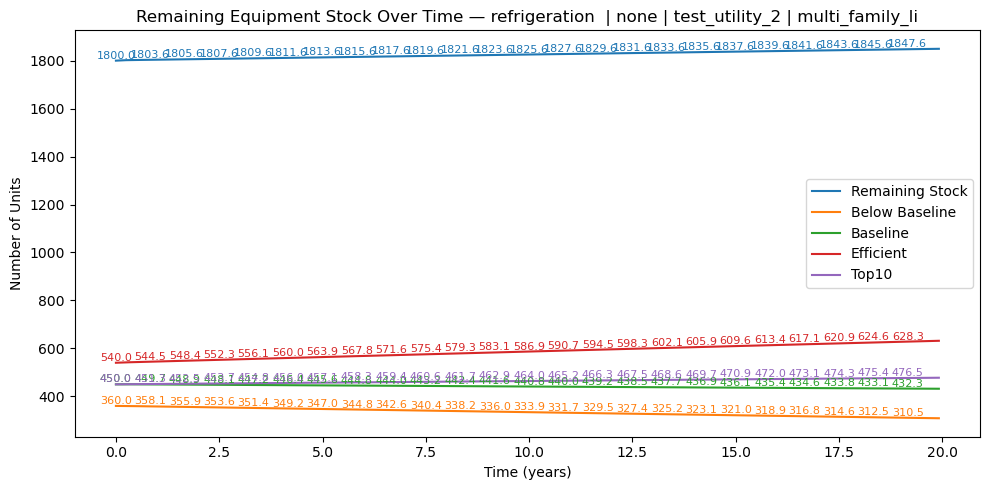

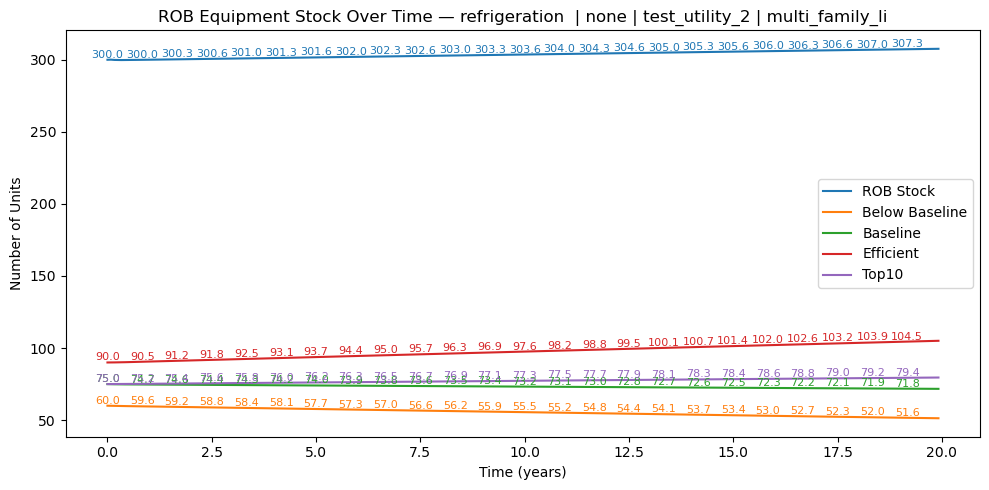

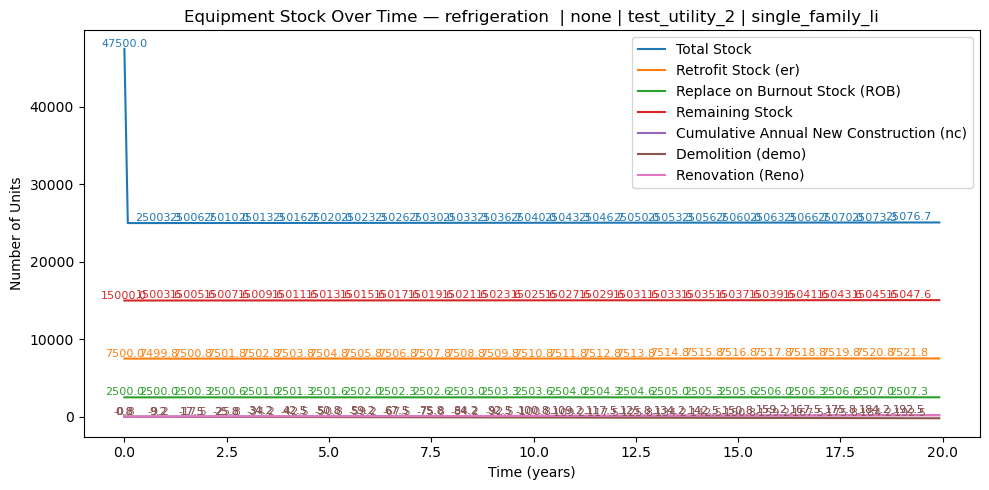

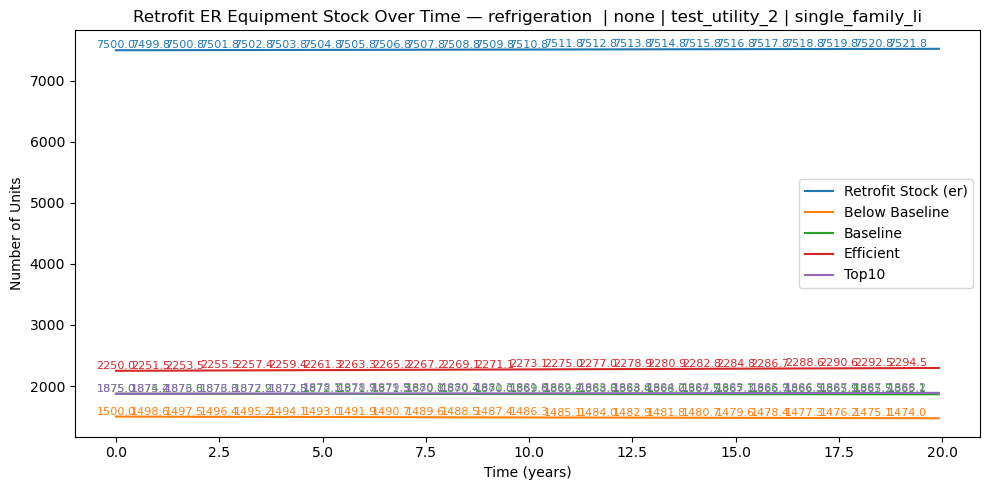

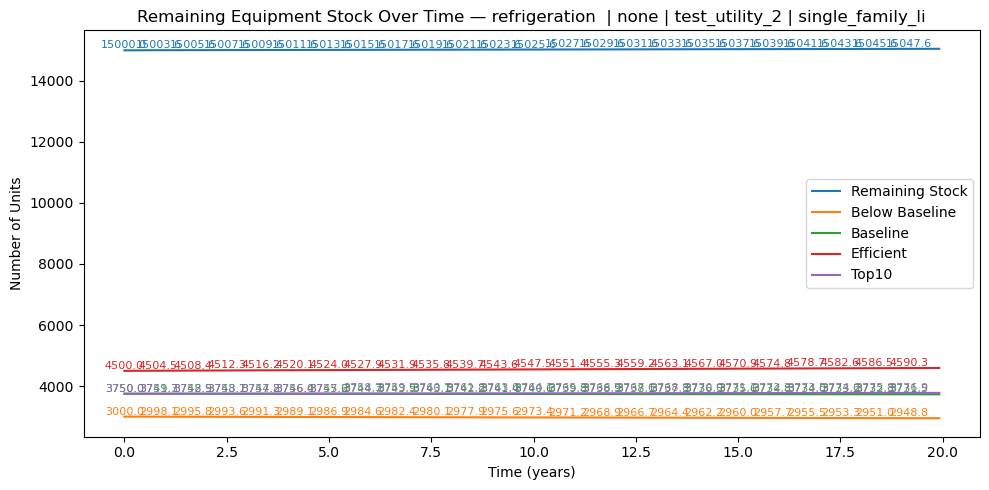

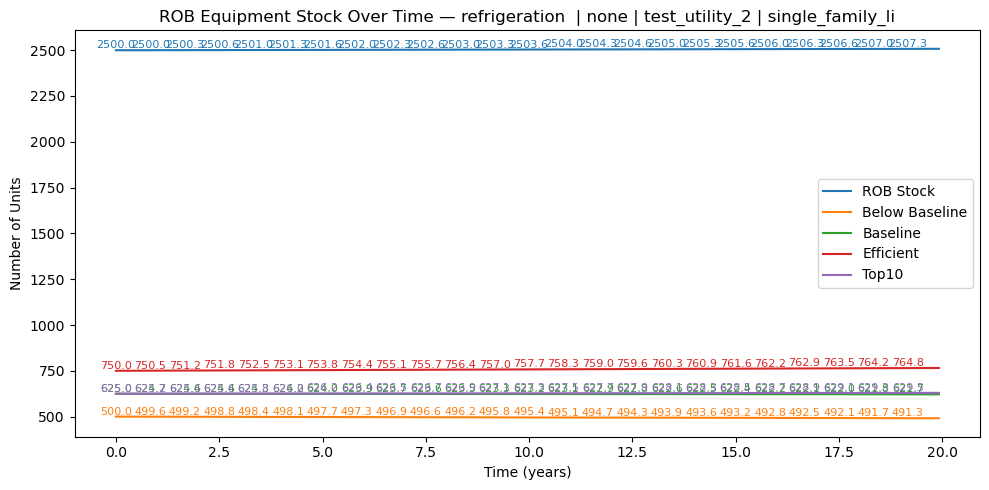

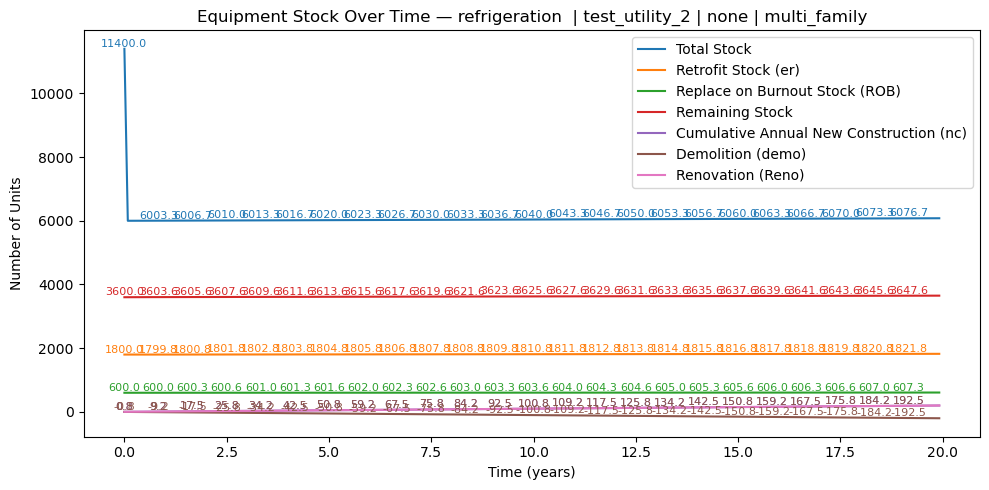

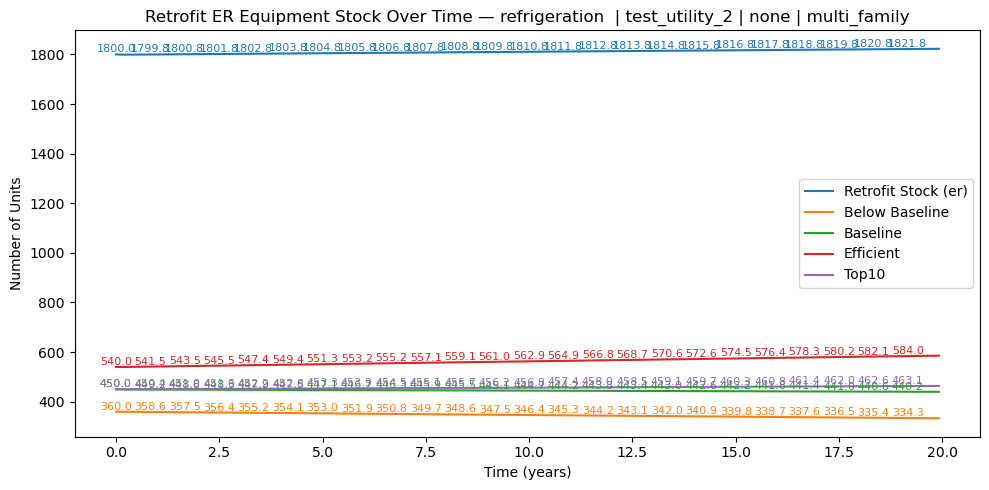

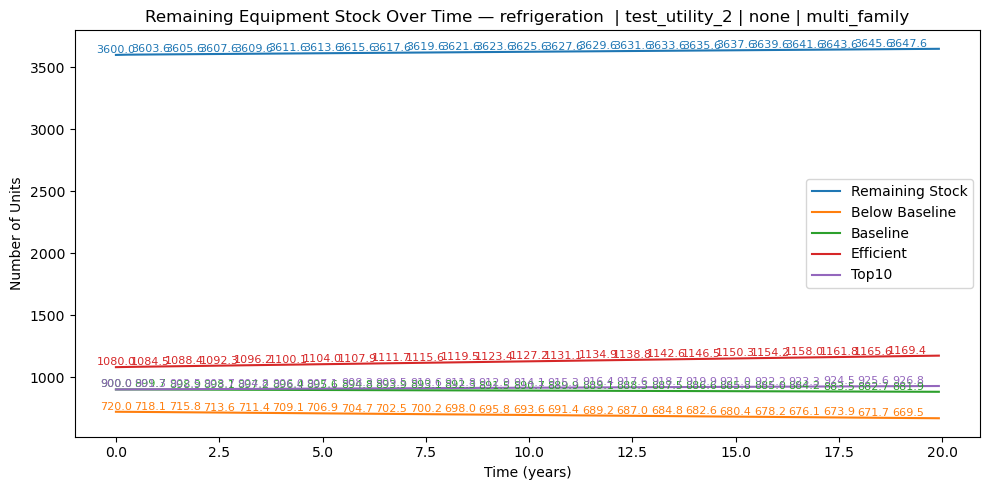

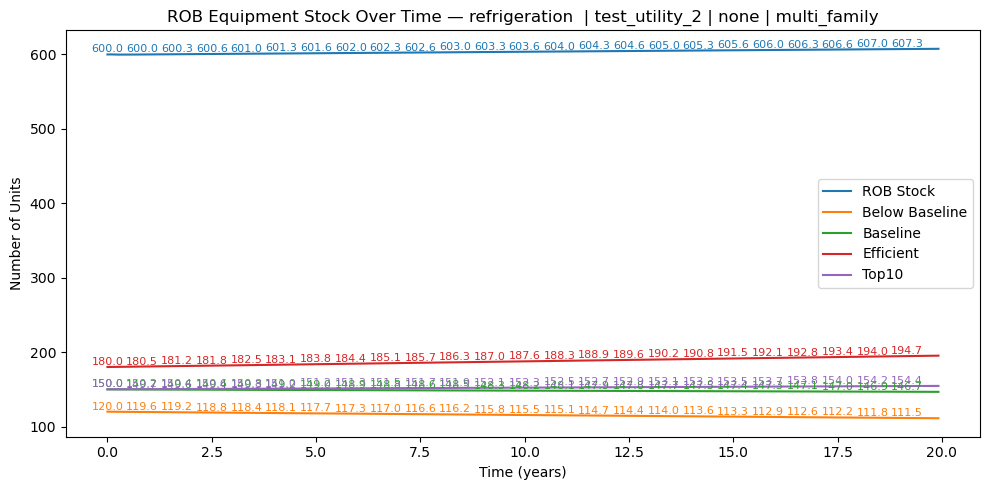

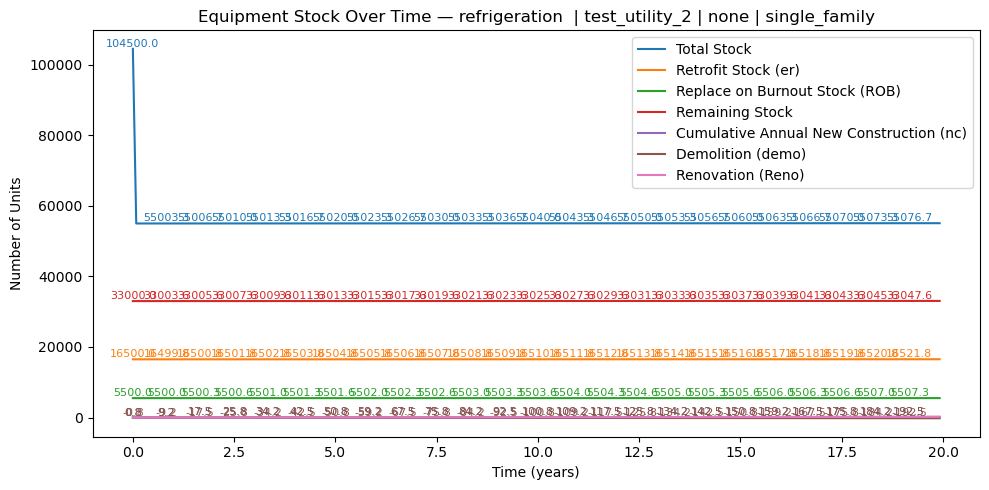

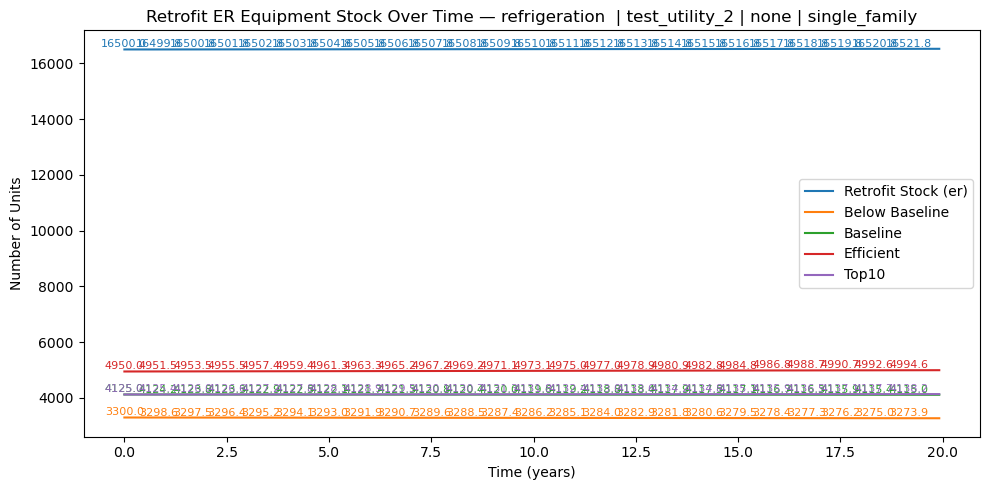

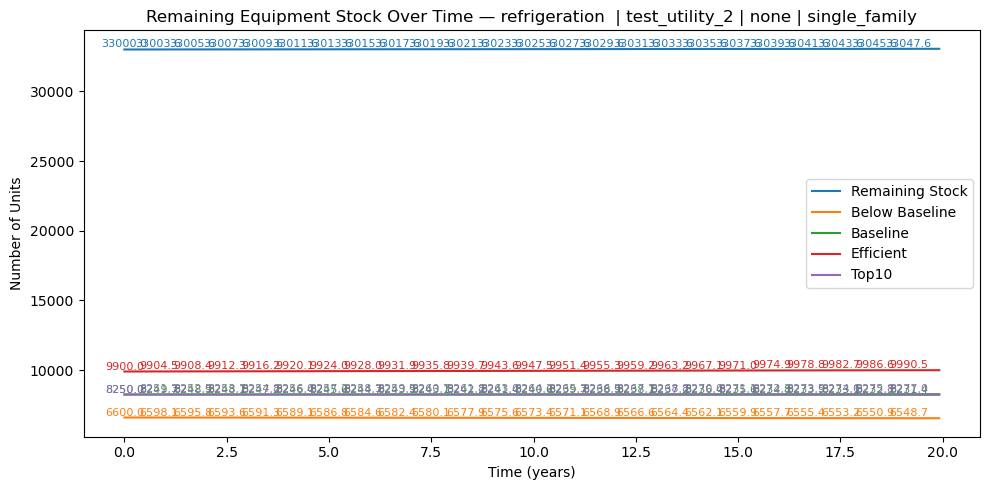

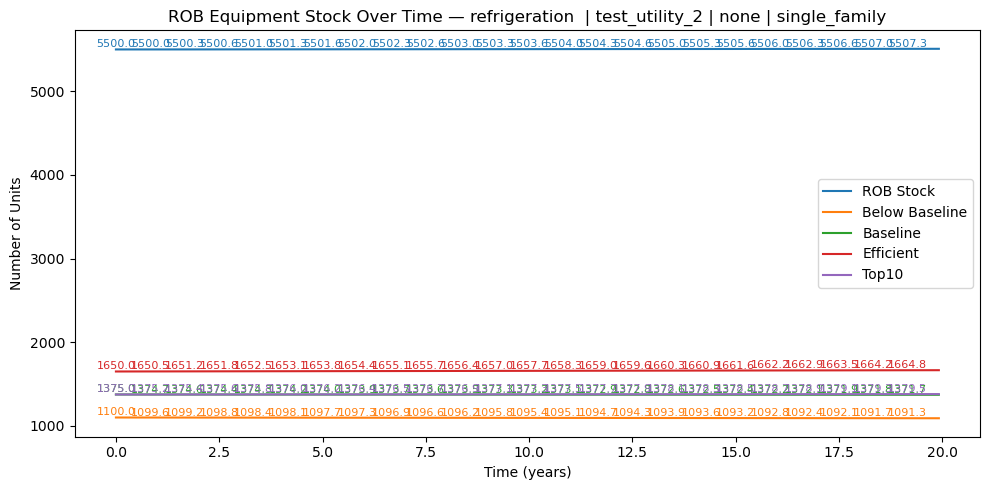

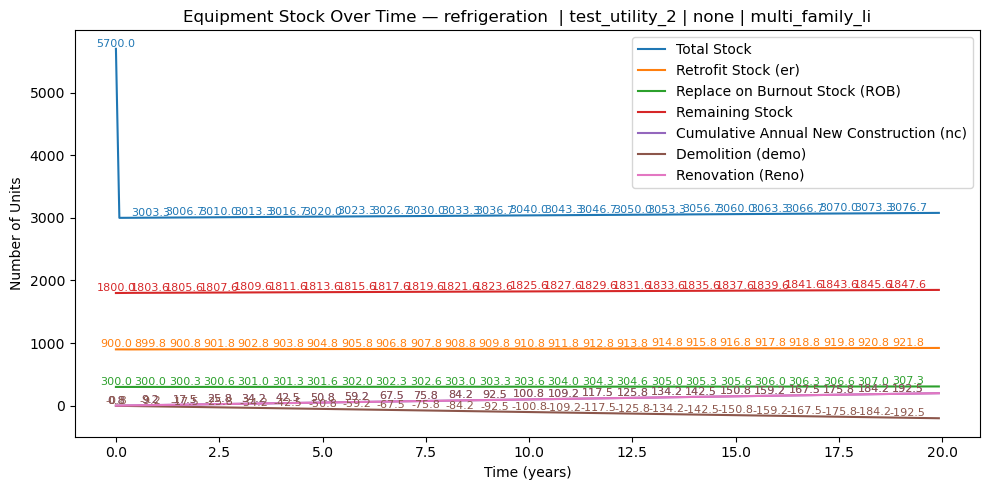

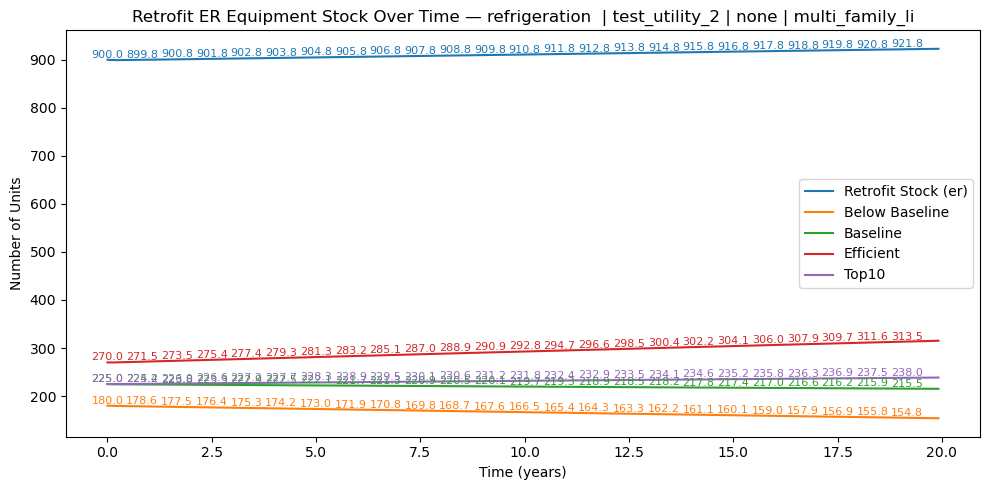

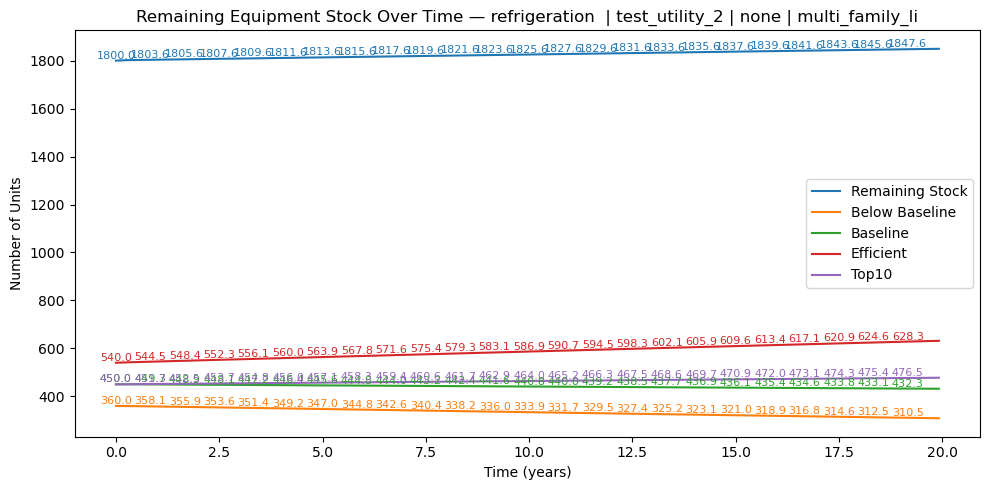

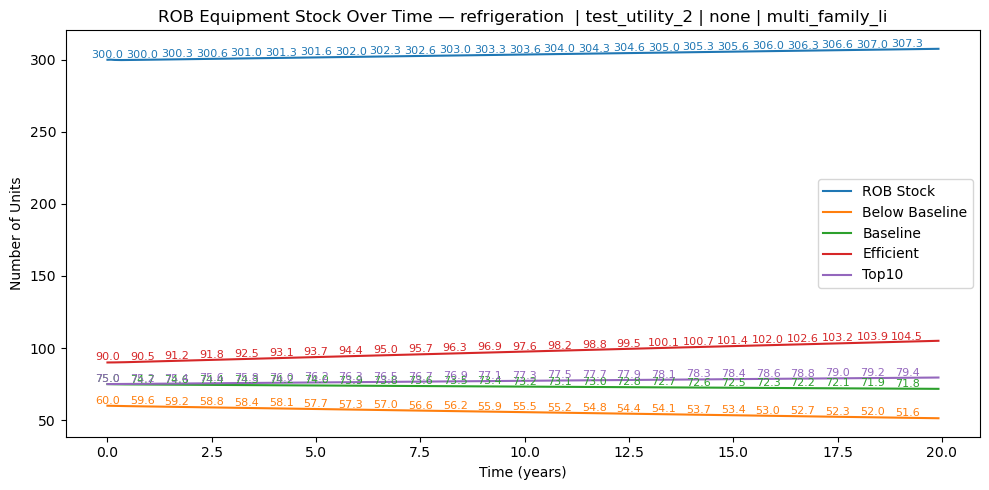

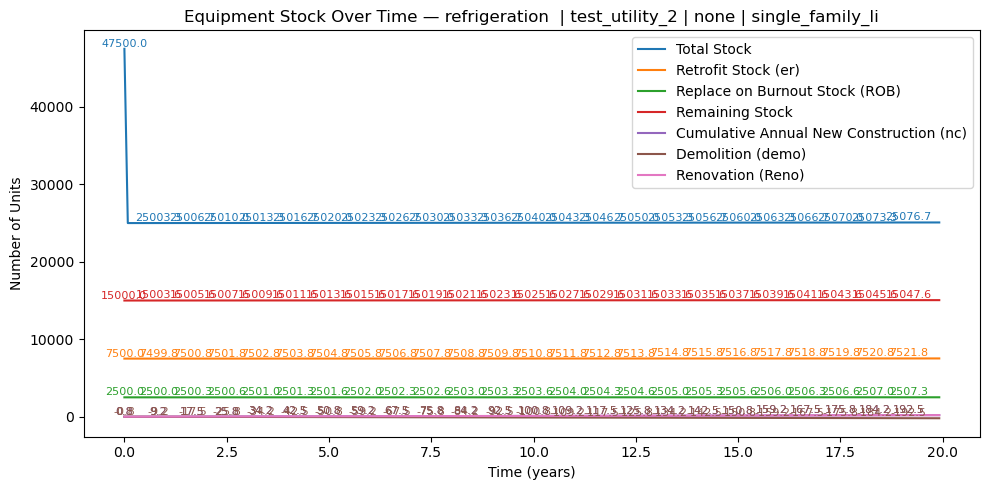

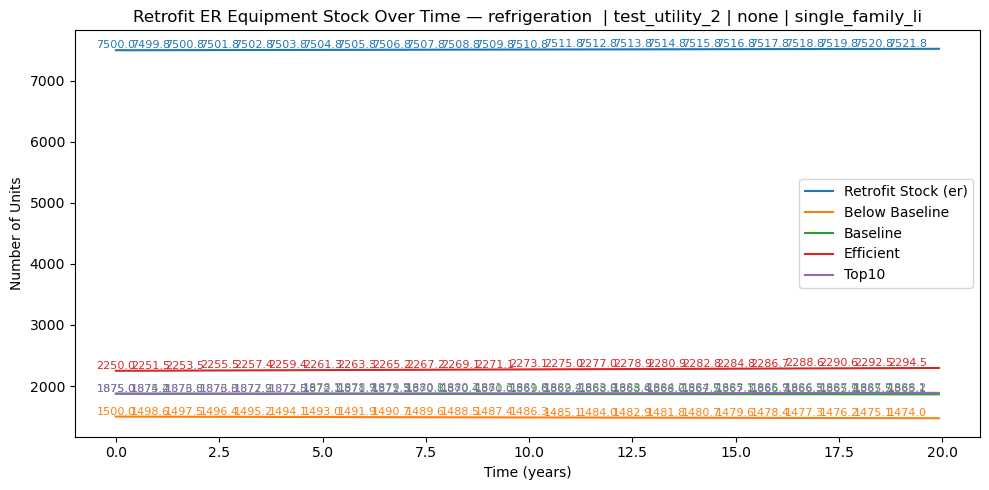

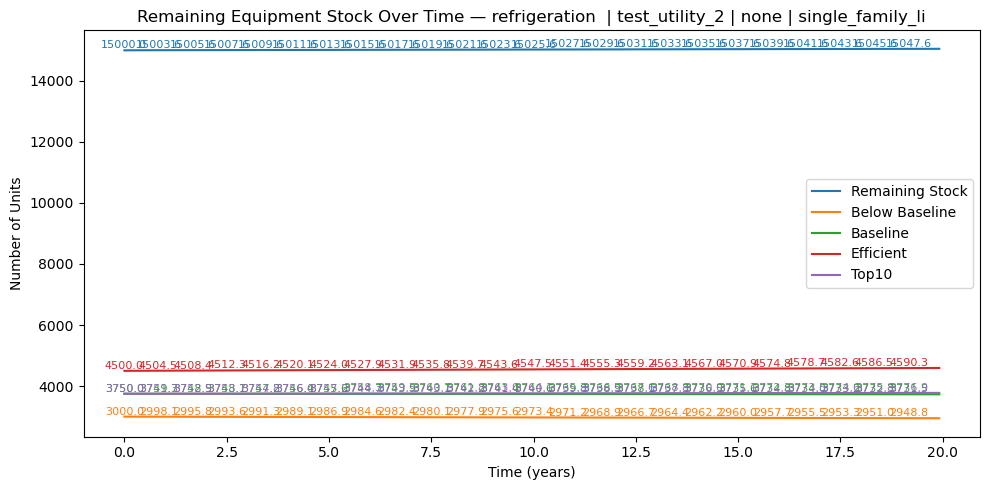

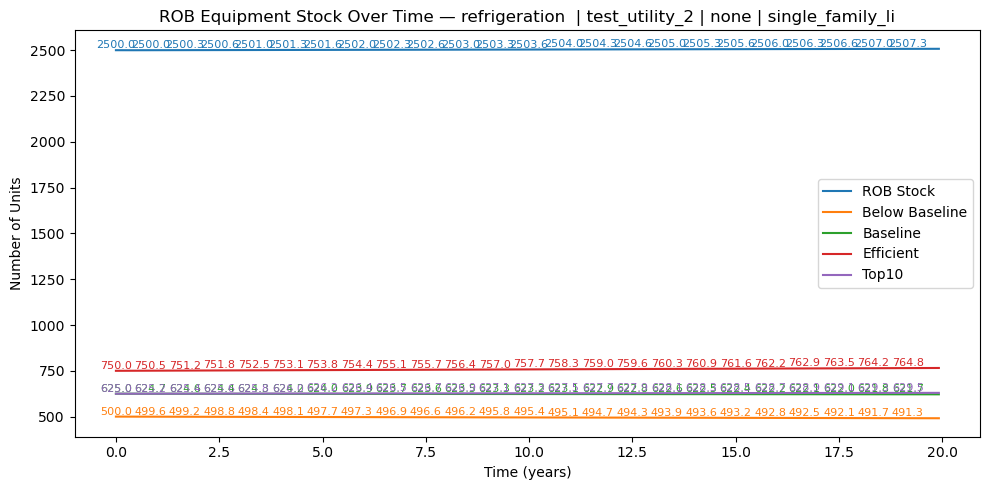

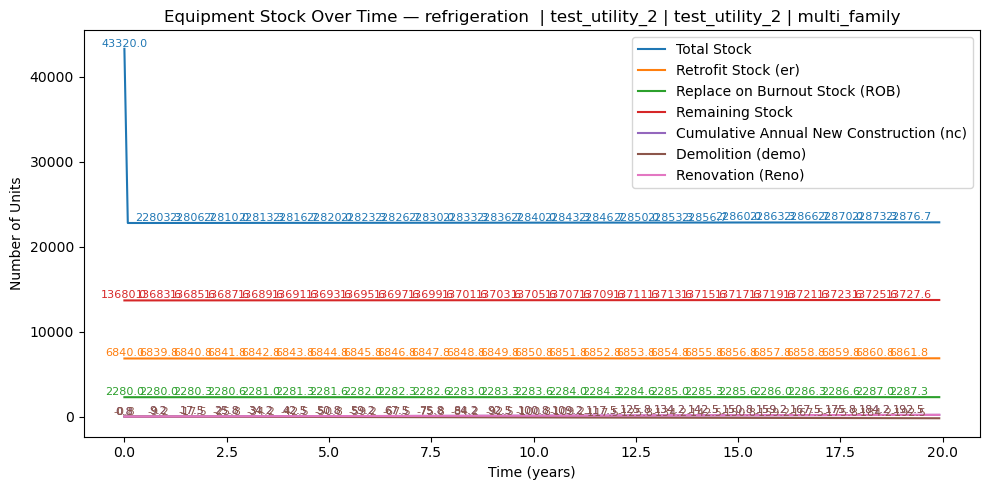

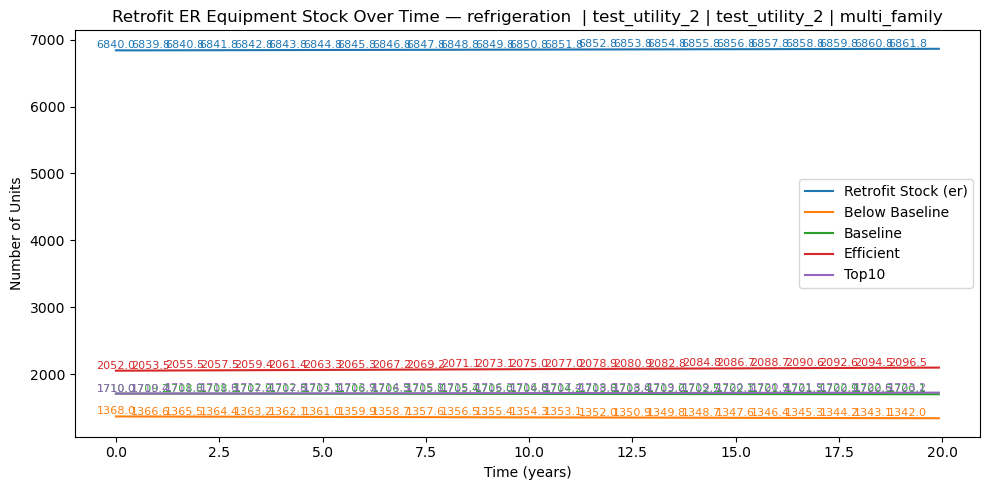

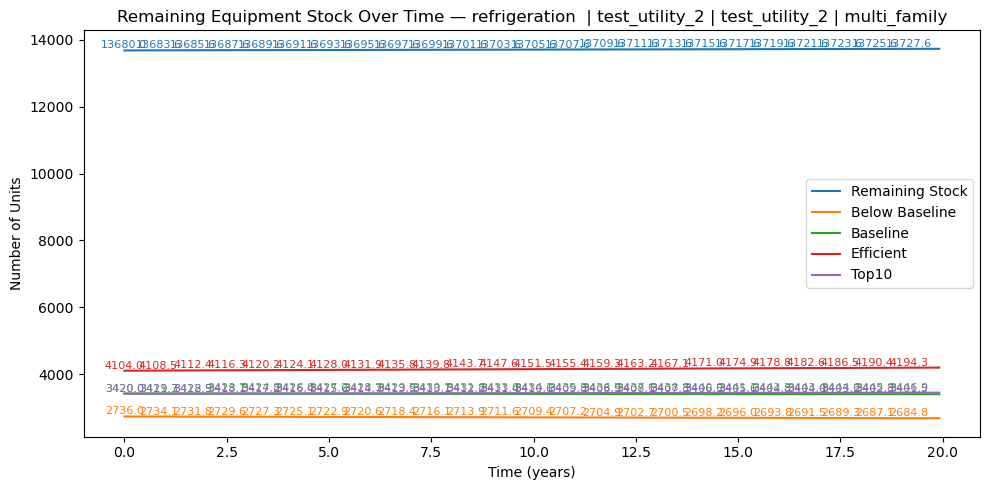

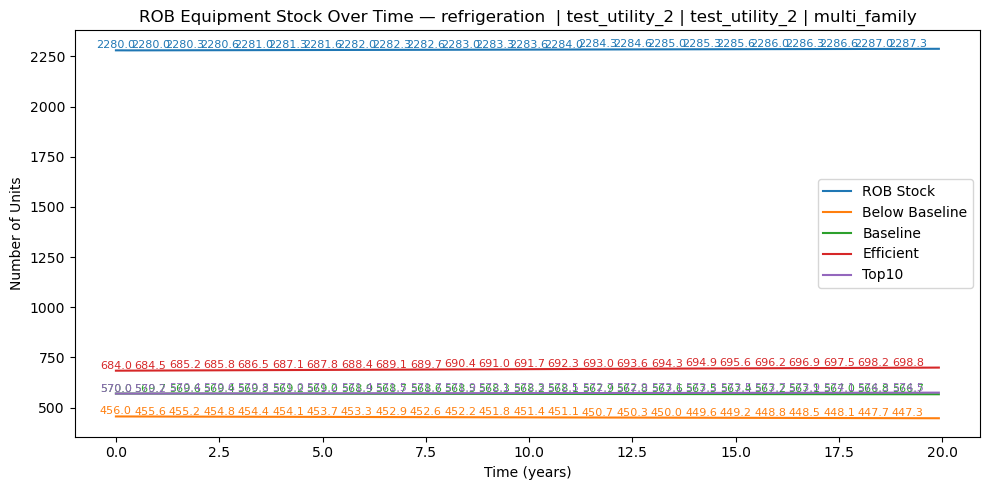

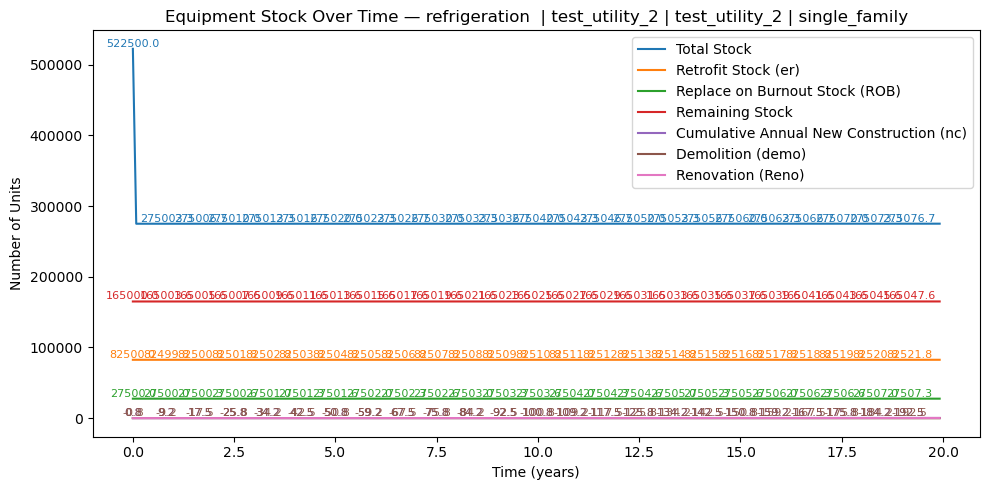

In [ ]:
# Plot results for each group combination
# import matplotlib.pyplot as plt

results_df = baseline_results_df  # Change to tech_results_df to plot tech scenario

# Columns that define a group
group_cols = ['competition_group','electric_utility','gas_utility','building_type'] #'subgroup',
unique_groups = results_df[group_cols].drop_duplicates()

for _, g in unique_groups.iterrows():
    # Build mask for this group
    mask = (
        (results_df['competition_group'] == g['competition_group']) &
       # (results_df['subgroup'] == g['subgroup']) &
        (results_df['electric_utility'] == g['electric_utility']) &
        (results_df['gas_utility'] == g['gas_utility']) &
        (results_df['building_type'] == g['building_type'])
    )
    dfg = results_df[mask].sort_values('time')
    if dfg.empty:
        continue
    t = dfg['time'].values

    # Figure title suffix describing the group
    title_suffix = f"{g['competition_group']}  | {g['electric_utility']} | {g['gas_utility']} | {g['building_type']}" # | {g['subgroup']}

    # --- Plot 1: overall stocks ---
    plt.figure(figsize=(10, 5))
    plt.plot(t, dfg['total_stock'].values, label="Total Stock")
    plt.plot(t, dfg['ret_er_stock'].values, label="Retrofit Stock (er)")
    plt.plot(t, dfg['rob_stock'].values, label="Replace on Burnout Stock (ROB)")
    plt.plot(t, dfg['remaining_stock'].values, label="Remaining Stock")
    # global cumulative arrays (length n) — plot them against the same time vector
    plt.plot(time, nc_cumulative_annual, label="Cumulative Annual New Construction (nc)")
    plt.plot(time, -demo_cumulative_annual, label="Demolition (demo)")
    plt.plot(time, reno_cumulative_annual, label="Renovation (Reno)")

    # Annotate every 10 timesteps (or fewer if short)
    step = max(1, int(len(t)/20))
    for i in range(0, len(t), 10):
        plt.text(t[i], dfg['total_stock'].values[i], f"{dfg['total_stock'].values[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:blue')
        plt.text(t[i], dfg['ret_er_stock'].values[i], f"{dfg['ret_er_stock'].values[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:orange')
        plt.text(t[i], dfg['rob_stock'].values[i], f"{dfg['rob_stock'].values[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:green')
        plt.text(t[i], dfg['remaining_stock'].values[i], f"{dfg['remaining_stock'].values[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:red')
        plt.text(t[i], nc_cumulative_annual[i], f"{nc_cumulative_annual[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:purple')
        plt.text(t[i], -demo_cumulative_annual[i], f"{-demo_cumulative_annual[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:brown')
        plt.text(t[i], reno_cumulative_annual[i], f"{reno_cumulative_annual[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:brown')

    plt.xlabel("Time (years)")
    plt.ylabel("Number of Units")
    plt.title("Equipment Stock Over Time — " + title_suffix)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Plot 2: Retrofit ER breakdown ---
    plt.figure(figsize=(10, 5))
    plt.plot(t, dfg['ret_er_stock'].values, label="Retrofit Stock (er)")
    plt.plot(t, dfg['ret_er_below_baseline_stock'].values, label="Below Baseline")
    plt.plot(t, dfg['ret_er_baseline_stock'].values, label="Baseline")
    plt.plot(t, dfg['ret_er_efficient_stock'].values, label="Efficient")
    plt.plot(t, dfg['ret_er_top10_stock'].values, label="Top10")
    for i in range(0, len(t), 10):
        plt.text(t[i], dfg['ret_er_stock'].values[i], f"{dfg['ret_er_stock'].values[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:blue')
        plt.text(t[i], dfg['ret_er_below_baseline_stock'].values[i], f"{dfg['ret_er_below_baseline_stock'].values[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:orange')
        plt.text(t[i], dfg['ret_er_baseline_stock'].values[i], f"{dfg['ret_er_baseline_stock'].values[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:green')
        plt.text(t[i], dfg['ret_er_efficient_stock'].values[i], f"{dfg['ret_er_efficient_stock'].values[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:red')
        plt.text(t[i], dfg['ret_er_top10_stock'].values[i], f"{dfg['ret_er_top10_stock'].values[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:purple')
    plt.xlabel("Time (years)")
    plt.ylabel("Number of Units")
    plt.title("Retrofit ER Equipment Stock Over Time — " + title_suffix)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Plot 3: Remaining breakdown ---
    plt.figure(figsize=(10, 5))
    plt.plot(t, dfg['remaining_stock'].values, label="Remaining Stock")
    plt.plot(t, dfg['remaining_below_baseline_stock'].values, label="Below Baseline")
    plt.plot(t, dfg['remaining_baseline_stock'].values, label="Baseline")
    plt.plot(t, dfg['remaining_efficient_stock'].values, label="Efficient")
    plt.plot(t, dfg['remaining_top10_stock'].values, label="Top10")
    for i in range(0, len(t), 10):
        plt.text(t[i], dfg['remaining_stock'].values[i], f"{dfg['remaining_stock'].values[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:blue')
        plt.text(t[i], dfg['remaining_below_baseline_stock'].values[i], f"{dfg['remaining_below_baseline_stock'].values[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:orange')
        plt.text(t[i], dfg['remaining_baseline_stock'].values[i], f"{dfg['remaining_baseline_stock'].values[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:green')
        plt.text(t[i], dfg['remaining_efficient_stock'].values[i], f"{dfg['remaining_efficient_stock'].values[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:red')
        plt.text(t[i], dfg['remaining_top10_stock'].values[i], f"{dfg['remaining_top10_stock'].values[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:purple')
    plt.xlabel("Time (years)")
    plt.ylabel("Number of Units")
    plt.title("Remaining Equipment Stock Over Time — " + title_suffix)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Plot 4: ROB breakdown ---
    plt.figure(figsize=(10, 5))
    plt.plot(t, dfg['rob_stock'].values, label="ROB Stock")
    plt.plot(t, dfg['rob_below_baseline_stock'].values, label="Below Baseline")
    plt.plot(t, dfg['rob_baseline_stock'].values, label="Baseline")
    plt.plot(t, dfg['rob_efficient_stock'].values, label="Efficient")
    plt.plot(t, dfg['rob_top10_stock'].values, label="Top10")
    for i in range(0, len(t), 10):
        plt.text(t[i], dfg['rob_stock'].values[i], f"{dfg['rob_stock'].values[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:blue')
        plt.text(t[i], dfg['rob_below_baseline_stock'].values[i], f"{dfg['rob_below_baseline_stock'].values[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:orange')
        plt.text(t[i], dfg['rob_baseline_stock'].values[i], f"{dfg['rob_baseline_stock'].values[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:green')
        plt.text(t[i], dfg['rob_efficient_stock'].values[i], f"{dfg['rob_efficient_stock'].values[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:red')
        plt.text(t[i], dfg['rob_top10_stock'].values[i], f"{dfg['rob_top10_stock'].values[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:purple')
    plt.xlabel("Time (years)")
    plt.ylabel("Number of Units")
    plt.title("ROB Equipment Stock Over Time — " + title_suffix)
    plt.legend()
    plt.tight_layout()
    plt.show()



# Done plotting all groups
print(f"Plotted {len(unique_groups)} group combinations.")